In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Tue Nov  4 23:35:35 PST 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Record versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [4]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@263eb3d9b80b13735a7380bb892430eaba92603a#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@3518d1cae7bb5ee1569707d90a8fa177403d5bc4#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.6/model_spec/2025_11_04_13_31_16/
```

Artifact:

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/
```

In [5]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [6]:
# Results directory containing model 7 results for all locations
model_run_subdir = 'results/model8.6/model_spec/2025_11_04_13_31_16/'
!ls -halt $model_run_subdir/results

total 137M
drwxrwsr-x 5 albrja IHME-Simulationscience 4.5K Nov  4 15:25 ..
drwxrwsr-x 2 albrja IHME-Simulationscience 6.5K Nov  4 15:24 .
-rw-rw-r-- 1 albrja IHME-Simulationscience 1.1M Nov  4 15:24 counts_bbbm_tests.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience  38M Nov  4 15:24 ylds.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 5.6M Nov  4 15:24 counts_baseline_tests_among_eligible.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 9.4M Nov  4 15:24 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 1.5M Nov  4 15:24 person_time_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience  19M Nov  4 15:24 ylls.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 1.4M Nov  4 15:24 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience  30M Nov  4 15:24 person_time_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 3.0M Nov  4 15:24 deaths.parque

In [7]:
!ls $model_run_subdir

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [8]:
!cat $model_run_subdir/model_specification.yaml | grep -e artifact -e results

      controller: vivarium.framework.artifact.ArtifactManager
      builder_interface: vivarium.framework.artifact.ArtifactInterface
    results:
      controller: vivarium.framework.results.ResultsManager
      builder_interface: vivarium.framework.results.ResultsInterface
    results:
      - bbbm_test_results
    results_directory: /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.6/model_spec/2025_11_04_13_31_16


In [9]:
locations = [
    'United States of America',
    # 'Brazil',
    # 'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '8.3' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf',
 'Sweden': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'}

In [10]:
location_to_results_dir

{'all': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.6/model_spec/2025_11_04_13_31_16/results/'}

# Define some ordered Categorical dtypes, and convert years to ints

In [11]:
# # Instead of creating this dtype here, create an appropriate dtype in
# # the load_sim_output function.
# # Order locations lexicographically
# all_locations = [
#     'United States of America',
#     'Brazil',
#     'China',
#     'Germany',
#     'Israel',
#     'Japan',
#     'Spain',
#     'Sweden',
#     'Taiwan (Province of China)',
#     'United Kingdom',
# ]
# location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    # 'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [12]:
artifact_path = location_to_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [13]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [14]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5    draw_6  \
0  0.527516  0.495529  0.464333  0.576056  0.478925  0.458396  0.541982   

     draw_7   draw_8    draw_9  ...  draw_490  draw_491  draw_492  draw_493  \
0  0.520483  0.53923  0.514836  ...  0.485136  0.498684  0.503797  0.432717   

   draw_494  draw_495  draw_496  draw_497  draw_498  draw_499  
0  0.462276  0.481699  0.569136  0.502568    0.4362  0.512734  

[1 rows x 500 columns]

# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [15]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [16]:
# Create an operator object - treat each random seed as a separate draw,
# and add location to the index
ops = VPHOperator(location_col=True)
# ops.index_cols.extend(['location', 'random_seed'])

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        # specify dtypes of certain columns
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    # Override optional transformations if raw=True
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    # Determine whether results for all locations are stored in same
    # directory, or if different locations have different results
    # directories
    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are concatenated" \
            " in the simulation outputs."
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Use logging not printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # NOTE: location_to_artifact_path is guaranteed not to
                # be None because assign_location and
                # all_locations_together are both True

                # Create a Categorical dtype with all locations
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_artifact_path.keys()), ordered=True)
                # Invert the dictionary so we can map artifact paths to
                # locations
                artifact_path_to_location = {
                    path: loc for loc, path
                    in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                # NOTE: location_to_results_dir contains actual
                # locations as keys (not 'all') since
                # all_locations_together is False

                # Create a Categorical dtype with all locations to avoid
                # converting back to object dtype.
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_results_dir.keys()), ordered=True)
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    # TODO: Maybe if assign_location is False and all_locations_together
    # is also False (and there is more than one location?), we should
    # return a dict mapping locations to dataframes (or just a list of
    # dataframes?) instead of concatenating, since it won't be possible
    # to filter the resulting concatenated dataframe by location...
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Test code for loading sim output

In [17]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
    # aggregate_seeds=False,
)
new_sims

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])


age_group  event_year     sex  \
0        25_to_29        2022  Female   
1        25_to_29        2022    Male   
2        25_to_29        2023  Female   
3        25_to_29        2023    Male   
4        25_to_29        2024  Female   
...           ...         ...     ...   
1777495   95_plus        2098    Male   
1777496   95_plus        2099  Female   
1777497   95_plus        2099    Male   
1777498   95_plus        2100  Female   
1777499   95_plus        2100    Male   

                                             artifact_path  \
0        /mnt/team/simulation_science/pub/models/vivari...   
1        /mnt/team/simulation_science/pub/models/vivari...   
2        /mnt/team/simulation_science/pub/models/vivari...   
3        /mnt/team/simulation_science/pub/models/vivari...   
4        /mnt/team/simulation_science/pub/models/vivari...   
...                                                    ...   
1777495  /mnt/team/simulation_science/pub/models/vivari...   
1777496  /mnt/team/simulation_science/pub/models/vivari...   
1777497  /mnt/team/simulation_science/pub/models/vivari...   
1777498  /mnt/team/simulation_science/pub/models/vivari...   
1777499  /mnt/team/simulation_science/pub/models/vivari...   

                           scenario  input_draw  random_seed  value  
0                          baseline         258         2284    0.0  
1                          baseline         258         2284    0.0  
2                          baseline         258         2284    0.0  
3                          baseline         258         2284    0.0  
4                          baseline         258         2284    0.0  
...                             ...         ...          ...    ...  
1777495  bbbm_testing_and_treatment         113         4344    0.0  
1777496  bbbm_testing_and_treatment         113         4344    0.0  
1777497  bbbm_testing_and_treatment         113         4344    0.0  
1777498  bbbm_testing_and_treatment         113         4344    0.0  
1777499  bbbm_testing_and_treatment         113         4344    0.0  

[1777500 rows x 8 columns]

In [18]:
print(
    new_sims.artifact_path.unique(),
    new_sims.input_draw.unique(),
    # new_sims.random_seed.nunique(),
    new_sims.scenario.unique(),
    new_sims.event_year.unique(),
    sep='\n'
)
if 'location' in new_sims:
    print(new_sims.location.unique())

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf']
[258 273 323 265 457  13 356 158   2 177 499 392 480  41 113 262 169  46
 317 460  89 346  24 199 446]
['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']
[2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035
 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049
 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063
 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100]


In [19]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777500 entries, 0 to 1777499
Data columns (total 8 columns):
 #   Column         Dtype   
---  ------         -----   
 0   age_group      category
 1   event_year     int16   
 2   sex            category
 3   artifact_path  object  
 4   scenario       category
 5   input_draw     int64   
 6   random_seed    int64   
 7   value          float64 
dtypes: category(3), float64(1), int16(1), int64(2), object(1)
memory usage: 62.7+ MB


In [20]:
new_sims['scenario']

0                            baseline
1                            baseline
2                            baseline
3                            baseline
4                            baseline
                      ...            
1777495    bbbm_testing_and_treatment
1777496    bbbm_testing_and_treatment
1777497    bbbm_testing_and_treatment
1777498    bbbm_testing_and_treatment
1777499    bbbm_testing_and_treatment
Name: scenario, Length: 1777500, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Define plotting functions

In [21]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [22]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])
63.995165 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2022        258  person_time   
1        treatment       cause        2022        258  person_time   
2        treatment       cause        2022        258  person_time   
3        treatment       cause        2022        258  person_time   
4        treatment       cause        2022        258  person_time   
...            ...         ...         ...        ...          ...   
3199495  treatment       cause        2100        446  person_time   
3199496  treatment       cause        2100        446  person_time   
3199497  treatment       cause        2100        446  person_time   
3199498  treatment       cause        2100        446  person_time   
3199499  treatment       cause        2100        446  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female     waiting_for_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
3199495  bbbm_testing_and_treatment    Male        waning_effect_long   
3199496  bbbm_testing_and_treatment    Male       waning_effect_short   
3199497  bbbm_testing_and_treatment    Male      no_effect_after_long   
3199498  bbbm_testing_and_treatment    Male     no_effect_after_short   
3199499  bbbm_testing_and_treatment    Male   no_effect_never_treated   

             value                  location  
0         0.000000                    Sweden  
1         0.000000                    Sweden  
2         0.000000                    Sweden  
3         0.000000                    Sweden  
4         0.000000                    Sweden  
...            ...                       ...  
3199495   0.000000  United States of America  
3199496   0.000000  United States of America  
3199497  40.859685  United States of America  
3199498   3.488022  United States of America  
3199499  80.722793  United States of America  

[3199500 rows x 12 columns]

In [23]:
person_time_treatment.event_year.unique()

array([2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
       2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054,
       2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065,
       2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076,
       2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100], dtype=int16)

In [24]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [25]:
person_time_treatment.query("sub_entity == 'waiting_for_treatment'")

age_group                                      artifact_path  \
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
10       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
19       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
28       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
37       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199456   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199465   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199474   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199483   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199492   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
1        treatment       cause        2022        258  person_time   
10       treatment       cause        2022        258  person_time   
19       treatment       cause        2022        258  person_time   
28       treatment       cause        2022        258  person_time   
37       treatment       cause        2022        258  person_time   
...            ...         ...         ...        ...          ...   
3199456  treatment       cause        2100        446  person_time   
3199465  treatment       cause        2100        446  person_time   
3199474  treatment       cause        2100        446  person_time   
3199483  treatment       cause        2100        446  person_time   
3199492  treatment       cause        2100        446  person_time   

                           scenario     sex             sub_entity  value  \
1                          baseline  Female  waiting_for_treatment    0.0   
10                         baseline    Male  waiting_for_treatment    0.0   
19                     bbbm_testing  Female  waiting_for_treatment    0.0   
28                     bbbm_testing    Male  waiting_for_treatment    0.0   
37       bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
...                             ...     ...                    ...    ...   
3199456                    baseline    Male  waiting_for_treatment    0.0   
3199465                bbbm_testing  Female  waiting_for_treatment    0.0   
3199474                bbbm_testing    Male  waiting_for_treatment    0.0   
3199483  bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
3199492  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   

                         location  
1                          Sweden  
10                         Sweden  
19                         Sweden  
28                         Sweden  
37                         Sweden  
...                           ...  
3199456  United States of America  
3199465  United States of America  
3199474  United States of America  
3199483  United States of America  
3199492  United States of America  

[355500 rows x 12 columns]

# Load treatment transition counts

In [26]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print_memory_usage(transition_count_treatment)
transition_count_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])
56.885281 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2843995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw           measure  \
0        treatment       cause        2022        258  transition_count   
1        treatment       cause        2022        258  transition_count   
2        treatment       cause        2022        258  transition_count   
3        treatment       cause        2022        258  transition_count   
4        treatment       cause        2022        258  transition_count   
...            ...         ...         ...        ...               ...   
2843995  treatment       cause        2100        446  transition_count   
2843996  treatment       cause        2100        446  transition_count   
2843997  treatment       cause        2100        446  transition_count   
2843998  treatment       cause        2100        446  transition_count   
2843999  treatment       cause        2100        446  transition_count   

                           scenario     sex  \
0                          baseline  Female   
1                          baseline  Female   
2                          baseline  Female   
3                          baseline  Female   
4                          baseline  Female   
...                             ...     ...   
2843995  bbbm_testing_and_treatment    Male   
2843996  bbbm_testing_and_treatment    Male   
2843997  bbbm_testing_and_treatment    Male   
2843998  bbbm_testing_and_treatment    Male   
2843999  bbbm_testing_and_treatment    Male   

                                                sub_entity  value  \
0                waiting_for_treatment_to_full_effect_long    0.0   
1               waiting_for_treatment_to_full_effect_short    0.0   
2                   full_effect_long_to_waning_effect_long    0.0   
3                 full_effect_short_to_waning_effect_short    0.0   
4               waning_effect_long_to_no_effect_after_long    0.0   
...                                                    ...    ...   
2843995           full_effect_short_to_waning_effect_short    0.0   
2843996         waning_effect_long_to_no_effect_after_long    0.0   
2843997       waning_effect_short_to_no_effect_after_short    0.0   
2843998  susceptible_to_treatment_to_waiting_for_treatment    0.0   
2843999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                         location  
0                          Sweden  
1                          Sweden  
2                          Sweden  
3                          Sweden  
4                          Sweden  
...                           ...  
2843995  United States of America  
2843996  United States of America  
2843997  United States of America  
2843998  United States of America  
2843999  United States of America  

[2844000 rows x 12 columns]

In [27]:
transition_count_treatment.sub_entity.unique()

['waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short', 'susceptible_to_treatment_to_waiting_for_treat..., 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (8, object): ['full_effect_long_to_waning_effect_long', 'full_effect_short_to_waning_effect_short', 'susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'waiting_for_treatment_to_full_effect_long', 'waiting_for_treatment_to_full_effect_short', 'waning_effect_long_to_no_effect_after_long', 'waning_effect_short_to_no_effect_after_short']

In [28]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

age_group                                      artifact_path  \
1336823  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1336831  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1336871  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1336879  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
1336919  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2085487  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
2085527  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
2085535  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
2085575  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
2085583  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw           measure  \
1336823  treatment       cause        2030        258  transition_count   
1336831  treatment       cause        2030        258  transition_count   
1336871  treatment       cause        2030        273  transition_count   
1336879  treatment       cause        2030        273  transition_count   
1336919  treatment       cause        2030        323  transition_count   
...            ...         ...         ...        ...               ...   
2085487  treatment       cause        2100         24  transition_count   
2085527  treatment       cause        2100        199  transition_count   
2085535  treatment       cause        2100        199  transition_count   
2085575  treatment       cause        2100        446  transition_count   
2085583  treatment       cause        2100        446  transition_count   

             scenario     sex  \
1336823  bbbm_testing  Female   
1336831  bbbm_testing    Male   
1336871  bbbm_testing  Female   
1336879  bbbm_testing    Male   
1336919  bbbm_testing  Female   
...               ...     ...   
2085487  bbbm_testing    Male   
2085527  bbbm_testing  Female   
2085535  bbbm_testing    Male   
2085575  bbbm_testing  Female   
2085583  bbbm_testing    Male   

                                                sub_entity   value  \
1336823  susceptible_to_treatment_to_no_effect_never_tr...   109.0   
1336831  susceptible_to_treatment_to_no_effect_never_tr...    75.0   
1336871  susceptible_to_treatment_to_no_effect_never_tr...    94.0   
1336879  susceptible_to_treatment_to_no_effect_never_tr...    61.0   
1336919  susceptible_to_treatment_to_no_effect_never_tr...   140.0   
...                                                    ...     ...   
2085487  susceptible_to_treatment_to_no_effect_never_tr...   554.0   
2085527  susceptible_to_treatment_to_no_effect_never_tr...  2016.0   
2085535  susceptible_to_treatment_to_no_effect_never_tr...   913.0   
2085575  susceptible_to_treatment_to_no_effect_never_tr...   936.0   
2085583  susceptible_to_treatment_to_no_effect_never_tr...   330.0   

                         location  
1336823                    Sweden  
1336831                    Sweden  
1336871                    Sweden  
1336879                    Sweden  
1336919                    Sweden  
...                           ...  
2085487  United States of America  
2085527  United States of America  
2085535  United States of America  
2085575  United States of America  
2085583  United States of America  

[28400 rows x 12 columns]

In [29]:
non_treatment_transitions.scenario.unique()

['bbbm_testing']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [30]:
list(non_treatment_transitions.sub_entity.unique())

['susceptible_to_treatment_to_no_effect_never_treated']

# Transform treatment transition counts into more useful form

In [31]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

19.917557 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
947995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
947999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
0       treatment       cause       2022        258                    Sweden   
1       treatment       cause       2022        258                    Sweden   
2       treatment       cause       2022        258                    Sweden   
3       treatment       cause       2022        258                    Sweden   
4       treatment       cause       2022        258                    Sweden   
...           ...         ...        ...        ...                       ...   
947995  treatment       cause       2100        446  United States of America   
947996  treatment       cause       2100        446  United States of America   
947997  treatment       cause       2100        446  United States of America   
947998  treatment       cause       2100        446  United States of America   
947999  treatment       cause       2100        446  United States of America   

                 measure                    scenario     sex  \
0       transition_count  bbbm_testing_and_treatment  Female   
1       transition_count  bbbm_testing_and_treatment  Female   
2       transition_count  bbbm_testing_and_treatment  Female   
3       transition_count  bbbm_testing_and_treatment  Female   
4       transition_count  bbbm_testing_and_treatment  Female   
...                  ...                         ...     ...   
947995  transition_count  bbbm_testing_and_treatment    Male   
947996  transition_count  bbbm_testing_and_treatment    Male   
947997  transition_count  bbbm_testing_and_treatment    Male   
947998  transition_count  bbbm_testing_and_treatment    Male   
947999  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
0               waiting_for_treatment_to_full_effect_long    0.0   
1              waiting_for_treatment_to_full_effect_short    0.0   
2                  full_effect_long_to_waning_effect_long    0.0   
3                full_effect_short_to_waning_effect_short    0.0   
4              waning_effect_long_to_no_effect_after_long    0.0   
...                                                   ...    ...   
947995           full_effect_short_to_waning_effect_short    0.0   
947996         waning_effect_long_to_no_effect_after_long    0.0   
947997       waning_effect_short_to_no_effect_after_short    0.0   
947998  susceptible_to_treatment_to_waiting_for_treatment    0.0   
947999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                      from_state                 to_state  
0          waiting_for_treatment         full_effect_long  
1          waiting_for_treatment        full_effect_short  
2               full_effect_long       waning_effect_long  
3              full_effect_short      waning_effect_short  
4             waning_effect_long     no_effect_after_long  
...                          ...                      ...  
947995         full_effect_short      waning_effect_short  
947996        waning_effect_long     no_effect_after_long  
947997       waning_effect_short    no_effect_after_sho

In [32]:
treatment_transitions.to_state

0                full_effect_long
1               full_effect_short
2              waning_effect_long
3             waning_effect_short
4            no_effect_after_long
                   ...           
947995        waning_effect_short
947996       no_effect_after_long
947997      no_effect_after_short
947998      waiting_for_treatment
947999    no_effect_never_treated
Name: to_state, Length: 948000, dtype: category
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> Lilly: “The percent of patients with a positive BBBM test who initiate
> treatment will vary by location and over time – but will not vary by
> age or sex. In the US: 30% of eligible patients initiate (constant
> 2030-2100); Japan: 80% of eligible patients initiate (constant
> 2030-2100); all other countries: 40% of eligible patients initiate in
> 2030, increasing linearly to 70% by 2035, remaining constant at 70%
> until 2100.””

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'waiting_for_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'waiting_for_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks good

At least for the countries I checked (Japan and Spain so far).



In [33]:
treatment_transitions.to_state.unique()

['full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [34]:
testing_eligible_age_groups = age_groups[7:11]
testing_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79']

In [35]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through
# 80-84. Note that these are the ages when people should enter one of
# the 'full_effect' states, not the 'waiting_for_treatment' state
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [36]:
# Verify that no one outside the testing-eligible age groups starts
#  waiting for treatment
treatment_transitions.query(
    "to_state == 'waiting_for_treatment'"
    " and age_group not in @testing_eligible_age_groups"
).value.unique()

array([0.])

In [37]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the testing-eligible age groups
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [38]:
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).groupby('age_group', observed=True).describe()

value                                                           
            count        mean         std   min    25%    50%    75%     max
age_group                                                                   
60_to_64   7100.0   78.969437   40.976117   1.0   47.0   74.0  104.0   233.0
65_to_69   7100.0  124.469718   76.670744   3.0   67.0  110.0  165.0   395.0
70_to_74   7100.0  270.359859  171.426377   8.0  144.0  227.0  341.0   939.0
75_to_79   7100.0  437.194507  281.400113  15.0  225.0  370.0  538.0  1617.0

In [39]:
ops.index_cols

['input_draw', 'scenario', 'location']

In [40]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    dropna=True,
)
initiate_vs_not

event_year  input_draw                    scenario  \
0           2030           2  bbbm_testing_and_treatment   
1           2030           2  bbbm_testing_and_treatment   
2           2030           2  bbbm_testing_and_treatment   
3           2030           2  bbbm_testing_and_treatment   
4           2030          13  bbbm_testing_and_treatment   
...          ...         ...                         ...   
7095        2100         480  bbbm_testing_and_treatment   
7096        2100         499  bbbm_testing_and_treatment   
7097        2100         499  bbbm_testing_and_treatment   
7098        2100         499  bbbm_testing_and_treatment   
7099        2100         499  bbbm_testing_and_treatment   

                      location                 to_state     value  \
0                       Sweden    waiting_for_treatment  0.407224   
1                       Sweden  no_effect_never_treated  0.592776   
2     United States of America    waiting_for_treatment  0.292912   
3     United States of America  no_effect_never_treated  0.707088   
4                       Sweden    waiting_for_treatment  0.417762   
...                        ...                      ...       ...   
7095  United States of America  no_effect_never_treated  0.696419   
7096                    Sweden    waiting_for_treatment  0.716385   
7097                    Sweden  no_effect_never_treated  0.283615   
7098  United States of America    waiting_for_treatment  0.298919   
7099  United States of America  no_effect_never_treated  0.701081   

     numerator_measure denominator_measure  multiplier  
0     transition_count    transition_count           1  
1     transition_count    transition_count           1  
2     transition_count    transition_count           1  
3     transition_count    transition_count           1  
4     transition_count    transition_count           1  
...                ...                 ...         ...  
7095  transition_count    transition_count           1  
7096  transition_count    transition_count           1  
7097  transition_count    transition_count           1  
7098  transition_count    transition_count           1  
7099  transition_count    transition_count           1  

[7100 rows x 9 columns]

In [41]:
initiate_vs_not.to_state.unique()

['waiting_for_treatment', 'no_effect_never_treated']
Categories (8, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

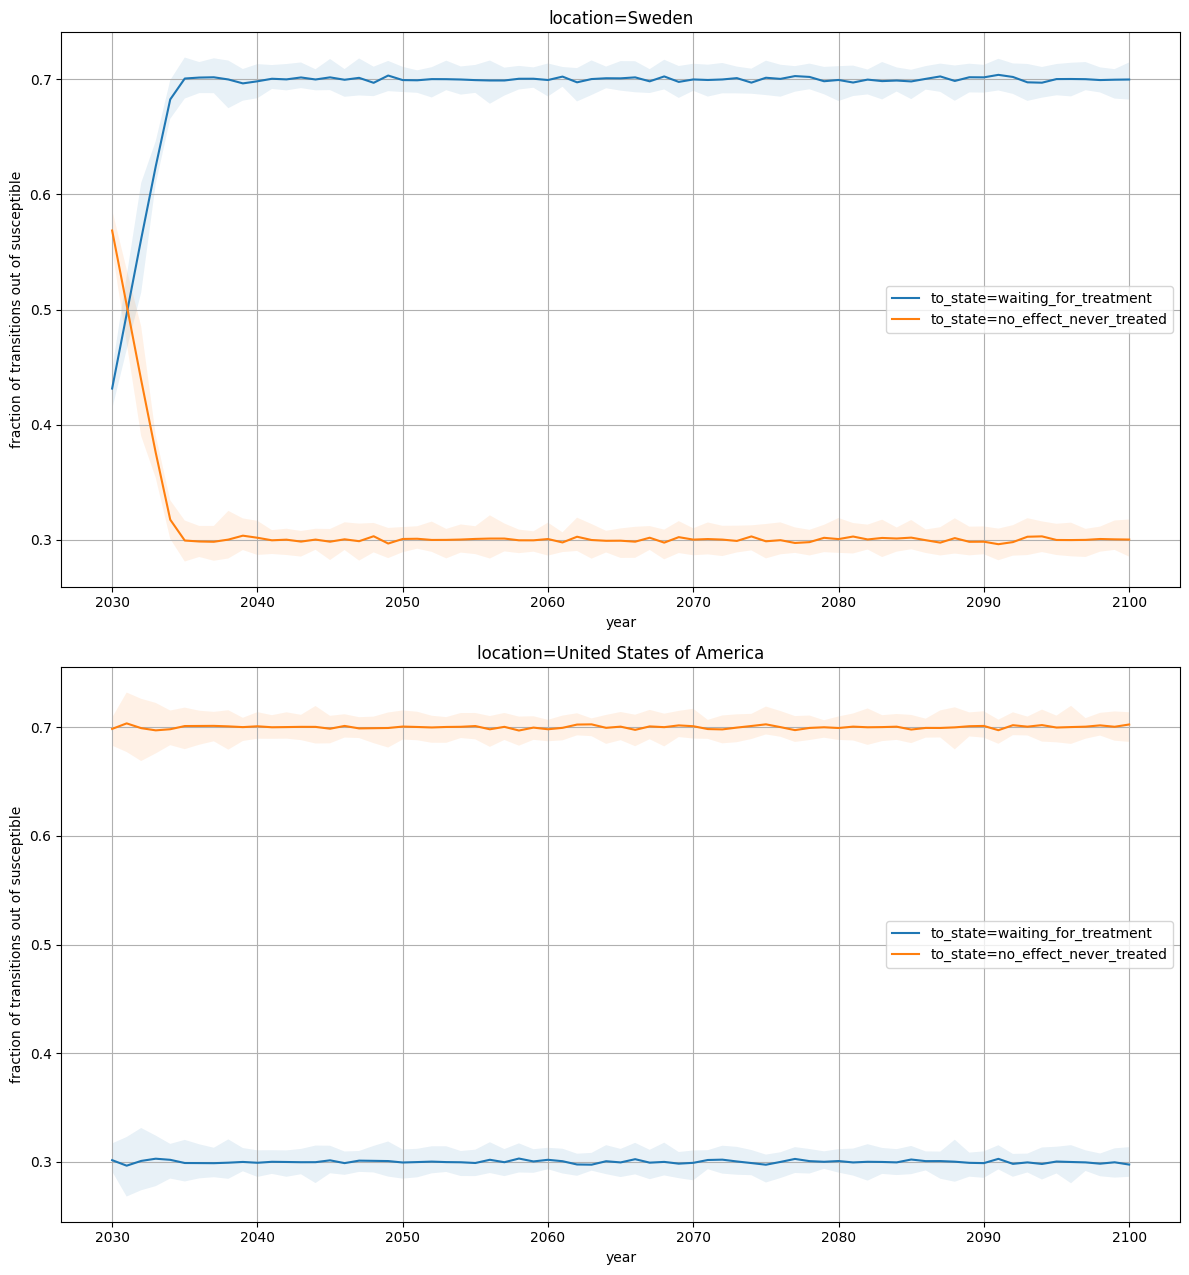

In [42]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Looks good

In [43]:
treatment_transitions.from_state.unique()

['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'susceptible_to_treatment']
Categories (6, object): ['full_effect_long', 'full_effect_short', 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [44]:
# This gives the fraction of the total transitions out of
# 'waiting_for_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

input_draw                    scenario                  location  \
0            2  bbbm_testing_and_treatment                    Sweden   
1            2  bbbm_testing_and_treatment                    Sweden   
2            2  bbbm_testing_and_treatment  United States of America   
3            2  bbbm_testing_and_treatment  United States of America   
4           13  bbbm_testing_and_treatment                    Sweden   
..         ...                         ...                       ...   
95         480  bbbm_testing_and_treatment  United States of America   
96         499  bbbm_testing_and_treatment                    Sweden   
97         499  bbbm_testing_and_treatment                    Sweden   
98         499  bbbm_testing_and_treatment  United States of America   
99         499  bbbm_testing_and_treatment  United States of America   

             to_state     value numerator_measure denominator_measure  \
0    full_effect_long  0.900255  transition_count    transition_count   
1   full_effect_short  0.099745  transition_count    transition_count   
2    full_effect_long  0.901197  transition_count    transition_count   
3   full_effect_short  0.098803  transition_count    transition_count   
4    full_effect_long  0.899063  transition_count    transition_count   
..                ...       ...               ...                 ...   
95  full_effect_short  0.099502  transition_count    transition_count   
96   full_effect_long  0.899580  transition_count    transition_count   
97  full_effect_short  0.100420  transition_count    transition_count   
98   full_effect_long  0.900111  transition_count    transition_count   
99  full_effect_short  0.099889  transition_count    transition_count   

    multiplier  
0            1  
1            1  
2            1  
3            1  
4            1  
..         ...  
95           1  
96           1  
97           1  
98           1  
99           1  

[100 rows x 8 columns]

In [45]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
# 8	2	bbbm_testing_and_treatment	Japan	8.956227	transition_count	transition_count	1
0.899560 / 0.100440

8.956192751891678

In [46]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

input_draw                    scenario                  location     value  \
0         258  bbbm_testing_and_treatment                    Sweden  8.977035   
1         258  bbbm_testing_and_treatment  United States of America  8.883768   
2         273  bbbm_testing_and_treatment                    Sweden  8.943319   
3         273  bbbm_testing_and_treatment  United States of America  9.085264   
4         323  bbbm_testing_and_treatment                    Sweden  9.044043   
5         323  bbbm_testing_and_treatment  United States of America  9.024665   
6         265  bbbm_testing_and_treatment                    Sweden  9.031577   
7         265  bbbm_testing_and_treatment  United States of America  8.997421   
8         457  bbbm_testing_and_treatment                    Sweden  9.035004   
9         457  bbbm_testing_and_treatment  United States of America  8.921125   
10         13  bbbm_testing_and_treatment                    Sweden  8.907170   
11         13  bbbm_testing_and_treatment  United States of America  9.026431   
12        356  bbbm_testing_and_treatment                    Sweden  9.030587   
13        356  bbbm_testing_and_treatment  United States of America  8.893619   
14        158  bbbm_testing_and_treatment                    Sweden  8.978936   
15        158  bbbm_testing_and_treatment  United States of America  9.090131   
16          2  bbbm_testing_and_treatment                    Sweden  9.025561   
17          2  bbbm_testing_and_treatment  United States of America  9.121115   
18        177  bbbm_testing_and_treatment                    Sweden  9.006747   
19        177  bbbm_testing_and_treatment  United States of America  9.006982   
20        499  bbbm_testing_and_treatment                    Sweden  8.958144   
21        499  bbbm_testing_and_treatment  United States of America  9.011140   
22        392  bbbm_testing_and_treatment                    Sweden  9.144363   
23        392  bbbm_testing_and_treatment  United States of America  9.105360   
24        480  bbbm_testing_and_treatment                    Sweden  9.044518   
25        480  bbbm_testing_and_treatment  United States of America  9.050097   
26         41  bbbm_testing_and_treatment                    Sweden  8.971892   
27         41  bbbm_testing_and_treatment  United States of America  9.071787   
28        113  bbbm_testing_and_treatment                    Sweden  8.956138   
29        113  bbbm_testing_and_treatment  United States of America  9.022013   
30        262  bbbm_testing_and_treatment                    Sweden  8.948369   
31        262  bbbm_testing_and_treatment  United States of America  8.965662   
32        169  bbbm_testing_and_treatment                    Sweden  8.965240   
33        169  bbbm_testing_and_treatment  United States of America  9.036127   
34         46  bbbm_testing_and_treatment                    Sweden  9.059126   
35         46  bbbm_testing_and_treatment  United States of America  9.100801   
36        317  bbbm_testing_and_treatment                    Sweden  8.978631   
37        317  bbbm_testing_and_treatment  United States of America  8.978281   
38        460  bbbm_testing_and_treatment                    Sweden  8.944307   
39        460  bbbm_testing_and_treatment  United States of America  9.048241   
40         89  bbbm_testing_and_treatment                    Sweden  9.139228   
41         89  bbbm_testing_and_treatment  United States of America  9.231238   
42        346  bbbm_testing_and_treatment                    Sweden  8.894886   
43        346  bbbm_testing_and_treatment  United States of America  8.721427   
44         24  bbbm_testing_and_treatment                    Sweden  9.006754   
45         24  bbbm_testing_and_treatment  United States of America  8.945008   
46        199  bbbm_testing_and_treatment                    Sweden  8.984252   
47        199  bbbm_testing_and_treatment  United States of America  8.935841   
48        446  bbbm_testing_and_tr

In [47]:
# NOTE: ops.describe explicitly calculates uncertainty over
# ops.draw_col, so setting the draw column to 'random_seed' makes this
# work. Another option would be to allow passing in the "uncertainty"
# column instead of always assuming it's the input draw.
summarize_sim_data(complete_to_discontinue_ratio)

count  \
denominator_measure location                 multiplier numerator_measure scenario                            
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment   25.0   

                                                                                                          mean  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment  8.998918   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.011968   

                                                                                                           std  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment  0.060388   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  0.098442   

                                                                                                           min  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment  8.894886   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  8.721427   

                                                                                                           25%  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment  8.958144   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  8.965662   

                                                                                                           50%  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment  8.984252   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.024665   

                                                                                                           75%  \
denominator_measure location                 multiplier numerator_measure scenario                               
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment  9.031577   
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.071787   

                                                                                                           max  
denominator_measure location                 multiplier numerator_measure scenario                              
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment  9.144363  
                    United States of America 1          transition_count  bbbm_testing_and_treatment  9.231238

In [48]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                   
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                                     full_effect_short   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long    25.0   
                                                                                                     full_effect_short   25.0   

                                                                                                                            mean  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899986   
                                                                                                     full_effect_short  0.100014   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.900110   
                                                                                                     full_effect_short  0.099890   

                                                                                                                             std  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment full_effect_long   0.000601   
                                                                                                     full_effect_short  0.000601   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.000989   
                                                                                                     full_effect_short  0.000989   

                                                                                                                             min  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment full_effect_long   0.898938   
                                                                                                     full_effect_short  0.098577   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.897134   
                                                                                                     full_effect_short  0.097740   

                                                                                                                             25%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                      
transition_count    Sweden                   1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899580   
                                                                                                     full_effect_short  0.099685   
                    United States of America 1          transition_count  bbbm_testing_and_treatment full_effect_long   0.899655   
                                                                                                     full_effect_short  0.099287   

                                                                                                                             50%  \
denominator_measure location             

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'waiting_for_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'waiting_for_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [49]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [50]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']

In [51]:
# Compute ratio of person-time in each state to the person-time in the
# "waiting_for_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'waiting_for_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030" #" and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

event_year  input_draw                    scenario  \
0            2030           2  bbbm_testing_and_treatment   
1            2030           2  bbbm_testing_and_treatment   
2            2030           2  bbbm_testing_and_treatment   
3            2030           2  bbbm_testing_and_treatment   
4            2030           2  bbbm_testing_and_treatment   
...           ...         ...                         ...   
17745        2100         499  bbbm_testing_and_treatment   
17746        2100         499  bbbm_testing_and_treatment   
17747        2100         499  bbbm_testing_and_treatment   
17748        2100         499  bbbm_testing_and_treatment   
17749        2100         499  bbbm_testing_and_treatment   

                       location             sub_entity      value  \
0                        Sweden  waiting_for_treatment   1.000000   
1                        Sweden       full_effect_long   0.000000   
2                        Sweden      full_effect_short   0.000000   
3                        Sweden     waning_effect_long   0.000000   
4                        Sweden    waning_effect_short   0.000000   
...                         ...                    ...        ...   
17745  United States of America  waiting_for_treatment   1.000000   
17746  United States of America       full_effect_long   8.825431   
17747  United States of America      full_effect_short   0.103448   
17748  United States of America     waning_effect_long  10.274425   
17749  United States of America    waning_effect_short   0.510057   

      numerator_measure denominator_measure  multiplier  
0           person_time         person_time           1  
1           person_time         person_time           1  
2           person_time         person_time           1  
3           person_time         person_time           1  
4           person_time         person_time           1  
...                 ...                 ...         ...  
17745       person_time         person_time           1  
17746       person_time         person_time           1  
17747       person_time         person_time           1  
17748       person_time         person_time           1  
17749       person_time         person_time           1  

[17750 rows x 9 columns]

In [52]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['waiting_for_treatment', 'duration']
)
tx_state_durations


duration  population_fraction  target_person_time_ratio
sub_entity                                                                    
waiting_for_treatment       0.5                  1.0                       1.0
full_effect_long            5.0                  0.9                       9.0
full_effect_short           0.5                  0.1                       0.1
waning_effect_long          9.0                  0.9                      16.2
waning_effect_short         2.5                  0.1                       0.5

In [53]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                       duration  pop_frac  pt_ratio
sub_entity                                         
waiting_for_treatment       0.5       1.0       1.0
full_effect_long            5.0       0.9       9.0
full_effect_short           0.5       0.1       0.1
waning_effect_long          9.0       0.9      16.2
waning_effect_short         2.5       0.1       0.5


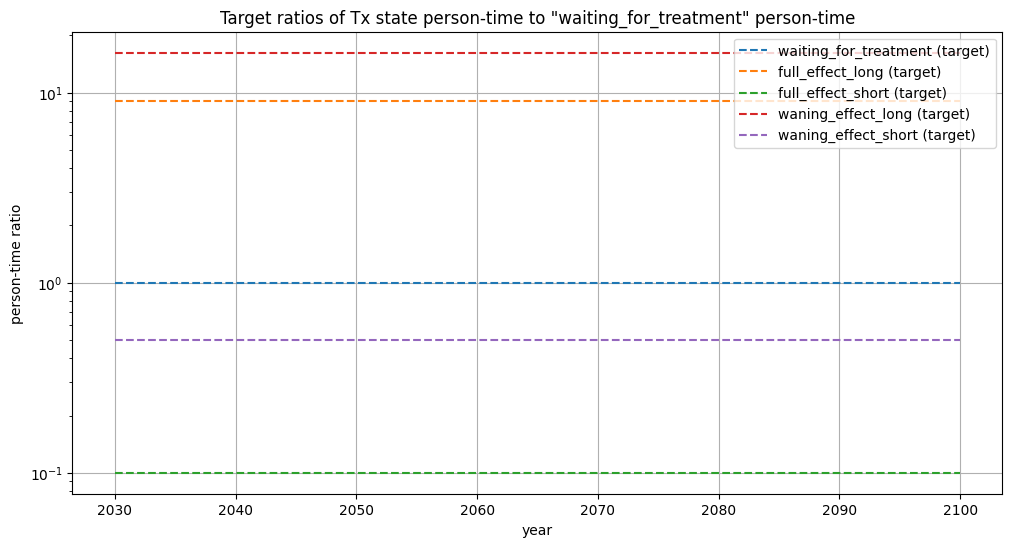

In [54]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "waiting_for_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

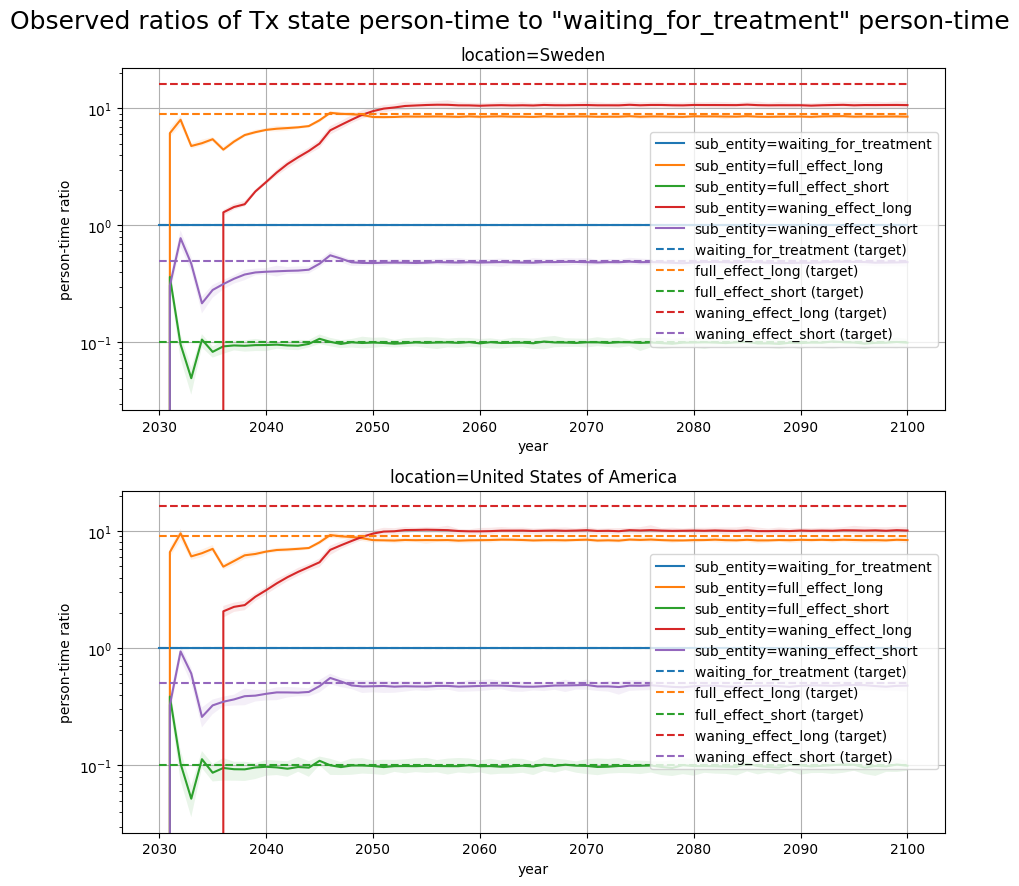

In [55]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "waiting_for_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

In [56]:
tx_person_time_ratios.groupby(['event_year', 'sub_entity'])['value'].describe()

count       mean       std       min  \
event_year sub_entity                                                    
2030       full_effect_long        50.0   0.000000  0.000000  0.000000   
           full_effect_short       50.0   0.000000  0.000000  0.000000   
           waiting_for_treatment   50.0   1.000000  0.000000  1.000000   
           waning_effect_long      50.0   0.000000  0.000000  0.000000   
           waning_effect_short     50.0   0.000000  0.000000  0.000000   
...                                 ...        ...       ...       ...   
2100       full_effect_long        50.0   8.428763  0.275008  7.805068   
           full_effect_short       50.0   0.099410  0.005068  0.088889   
           waiting_for_treatment   50.0   1.000000  0.000000  1.000000   
           waning_effect_long      50.0  10.371209  0.506430  9.367810   
           waning_effect_short     50.0   0.481871  0.025059  0.413619   

                                       25%        50%        75%        max  
event_year sub_entity                                                        
2030       full_effect_long       0.000000   0.000000   0.000000   0.000000  
           full_effect_short      0.000000   0.000000   0.000000   0.000000  
           waiting_for_treatment  1.000000   1.000000   1.000000   1.000000  
           waning_effect_long     0.000000   0.000000   0.000000   0.000000  
           waning_effect_short    0.000000   0.000000   0.000000   0.000000  
...                                    ...        ...        ...        ...  
2100       full_effect_long       8.261696   8.428346   8.596846   9.225470  
           full_effect_short      0.094819   0.099333   0.102903   0.110619  
           waiting_for_treatment  1.000000   1.000000   1.000000   1.000000  
           waning_effect_long     9.998226  10.310682  10.619053  11.528880  
           waning_effect_short    0.468246   0.481569   0.501021   0.540179  

[355 rows x 8 columns]

## Check values

In [57]:
tx_person_time_ratios.query("sub_entity == 'waning_effect_long' and event_year>2060").value.describe()

count    2000.000000
mean       10.355597
std         0.483714
min         9.033970
25%        10.003787
50%        10.351627
75%        10.707064
max        11.844757
Name: value, dtype: float64

In [58]:
tx_person_time_ratios.query("sub_entity == 'full_effect_long' and event_year>2060").value.describe()

count    2000.000000
mean        8.435834
std         0.211110
min         7.678954
25%         8.304367
50%         8.445486
75%         8.574725
max         9.225470
Name: value, dtype: float64

In [59]:
# Compute implied durations from the ratios above
# Target durations are (9, 5)
12.576105 / .9 * .5, 8.641488 / .9 * .5

(6.986725, 4.800826666666667)

In [60]:
ops.index_cols

['input_draw', 'scenario', 'location']

## Look at actual person-time instead of the ratio

In [61]:
ops.describe(
    ops.stratify(
        person_time_treatment.query(
            "value > 0 and "
            "(sub_entity == 'waiting_for_treatment' or "
            " sub_entity.str.endswith('effect_long')) and event_year > 2050"
            # " and location == 'Spain'"
        ),
        ['event_year', 'sub_entity']
    )
)

count  \
event_year location                 scenario                   sub_entity                     
2051       Sweden                   bbbm_testing_and_treatment waiting_for_treatment   25.0   
                                                               full_effect_long        25.0   
                                                               waning_effect_long      25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
                                                               full_effect_long        25.0   
...                                                                                     ...   
2100       Sweden                   bbbm_testing_and_treatment full_effect_long        25.0   
                                                               waning_effect_long      25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
                                                               full_effect_long        25.0   
                                                               waning_effect_long      25.0   

                                                                                              mean  \
event_year location                 scenario                   sub_entity                            
2051       Sweden                   bbbm_testing_and_treatment waiting_for_treatment   1664.424257   
                                                               full_effect_long       14003.849856   
                                                               waning_effect_long     16512.634524   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    754.887666   
                                                               full_effect_long        6269.828994   
...                                                                                            ...   
2100       Sweden                   bbbm_testing_and_treatment full_effect_long       14191.445640   
                                                               waning_effect_long     17776.255168   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    756.661574   
                                                               full_effect_long        6314.854374   
                                                               waning_effect_long      7606.339329   

                                                                                              std  \
event_year location                 scenario                   sub_entity                           
2051       Sweden                   bbbm_testing_and_treatment waiting_for_treatment   146.144425   
                                                               full_effect_long       1043.891226   
                                                               waning_effect_long      919.955149   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    73.488804   
                                                               full_effect_long        565.216441   
...                                                                                           ...   
2100       Sweden                   bbbm_testing_and_treatment full_effect_long       1099.973862   
                                                               waning_effect_long     1088.254620   
           United States of America bbbm_testing_and_treatment waiting_for_treatment    70.186261   
                                                               full_effect_long        535.451105   
                                                               waning_effect_long      534.850482   

                                                                                               min  \
event_year location                 scenario                   sub_entity                            
2051 

In [62]:
9721.296427 / 1129.481287

8.606868071998433

In [63]:
13995.099904 / 1129.481287

12.390731980316554

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is particularly close to the target
duration of 9 years. We think this is probably due to mortality.

In [64]:
person_time_treatment

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
3199495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
3199499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2022        258  person_time   
1        treatment       cause        2022        258  person_time   
2        treatment       cause        2022        258  person_time   
3        treatment       cause        2022        258  person_time   
4        treatment       cause        2022        258  person_time   
...            ...         ...         ...        ...          ...   
3199495  treatment       cause        2100        446  person_time   
3199496  treatment       cause        2100        446  person_time   
3199497  treatment       cause        2100        446  person_time   
3199498  treatment       cause        2100        446  person_time   
3199499  treatment       cause        2100        446  person_time   

                           scenario     sex                sub_entity  \
0                          baseline  Female  susceptible_to_treatment   
1                          baseline  Female     waiting_for_treatment   
2                          baseline  Female          full_effect_long   
3                          baseline  Female         full_effect_short   
4                          baseline  Female        waning_effect_long   
...                             ...     ...                       ...   
3199495  bbbm_testing_and_treatment    Male        waning_effect_long   
3199496  bbbm_testing_and_treatment    Male       waning_effect_short   
3199497  bbbm_testing_and_treatment    Male      no_effect_after_long   
3199498  bbbm_testing_and_treatment    Male     no_effect_after_short   
3199499  bbbm_testing_and_treatment    Male   no_effect_never_treated   

             value                  location  
0         0.000000                    Sweden  
1         0.000000                    Sweden  
2         0.000000                    Sweden  
3         0.000000                    Sweden  
4         0.000000                    Sweden  
...            ...                       ...  
3199495   0.000000  United States of America  
3199496   0.000000  United States of America  
3199497  40.859685  United States of America  
3199498   3.488022  United States of America  
3199499  80.722793  United States of America  

[3199500 rows x 12 columns]

In [65]:
treatment_transitions.query("value>0")

age_group                                      artifact_path  \
445600  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445601  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445606  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445607  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
445608  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
884764  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884772  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884780  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884788  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   
884796  90_to_94  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
445600  treatment       cause       2030        258                    Sweden   
445601  treatment       cause       2030        258                    Sweden   
445606  treatment       cause       2030        258                    Sweden   
445607  treatment       cause       2030        258                    Sweden   
445608  treatment       cause       2030        258                    Sweden   
...           ...         ...        ...        ...                       ...   
884764  treatment       cause       2100         24  United States of America   
884772  treatment       cause       2100        199  United States of America   
884780  treatment       cause       2100        199  United States of America   
884788  treatment       cause       2100        446  United States of America   
884796  treatment       cause       2100        446  United States of America   

                 measure                    scenario     sex  \
445600  transition_count  bbbm_testing_and_treatment  Female   
445601  transition_count  bbbm_testing_and_treatment  Female   
445606  transition_count  bbbm_testing_and_treatment  Female   
445607  transition_count  bbbm_testing_and_treatment  Female   
445608  transition_count  bbbm_testing_and_treatment    Male   
...                  ...                         ...     ...   
884764  transition_count  bbbm_testing_and_treatment    Male   
884772  transition_count  bbbm_testing_and_treatment  Female   
884780  transition_count  bbbm_testing_and_treatment    Male   
884788  transition_count  bbbm_testing_and_treatment  Female   
884796  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
445600          waiting_for_treatment_to_full_effect_long   36.0   
445601         waiting_for_treatment_to_full_effect_short    5.0   
445606  susceptible_to_treatment_to_waiting_for_treatment   47.0   
445607  susceptible_to_treatment_to_no_effect_never_tr...   62.0   
445608          waiting_for_treatment_to_full_effect_long   22.0   
...                                                   ...    ...   
884764         waning_effect_long_to_no_effect_after_long   38.0   
884772         waning_effect_long_to_no_effect_after_long  156.0   
884780         waning_effect_long_to_no_effect_after_long   50.0   
884788         waning_effect_long_to_no_effect_after_long   55.0   
884796         waning_effect_long_to_no_effect_after_long   10.0   

                      from_state                 to_state  
445600     waiting_for_treatment         full_effect_long  
445601     waiting_for_treatment        full_effect_short  
445606  susceptible_to_treatment    waiting_for_treatment  
445607  susceptible_to_treatment  no_effect_never_treated  
445608     waiting_for_treatment         full_effect_long  
...                          ...                      ...  
884764        waning_effect_long     no_effect_after_long  
884772        waning_effect_long     no_effect_after_long  
884780        waning_effect_long     no_effect_after_lo

In [66]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

event_year             to_state  input_draw  \
0            2030     full_effect_long           2   
1            2030     full_effect_long           2   
2            2030     full_effect_long          13   
3            2030     full_effect_long          13   
4            2030     full_effect_long          24   
...           ...                  ...         ...   
31945        2100  waning_effect_short         460   
31946        2100  waning_effect_short         480   
31947        2100  waning_effect_short         480   
31948        2100  waning_effect_short         499   
31949        2100  waning_effect_short         499   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                    Sweden  0.000000   
1      bbbm_testing_and_treatment  United States of America  0.000000   
2      bbbm_testing_and_treatment                    Sweden  0.000000   
3      bbbm_testing_and_treatment  United States of America  0.000000   
4      bbbm_testing_and_treatment                    Sweden  0.000000   
...                           ...                       ...       ...   
31945  bbbm_testing_and_treatment  United States of America  2.290834   
31946  bbbm_testing_and_treatment                    Sweden  2.760654   
31947  bbbm_testing_and_treatment  United States of America  2.731079   
31948  bbbm_testing_and_treatment                    Sweden  2.584346   
31949  bbbm_testing_and_treatment  United States of America  2.491444   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

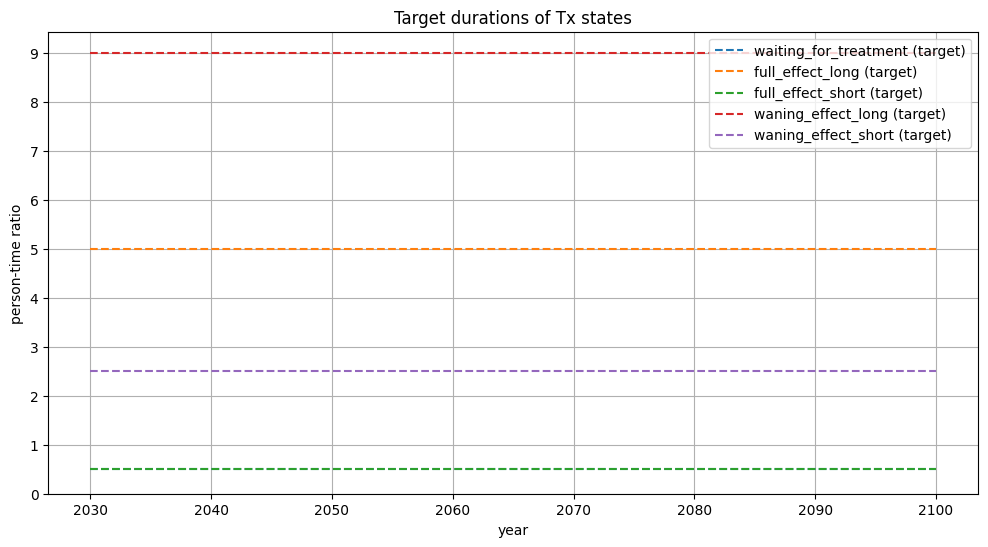

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

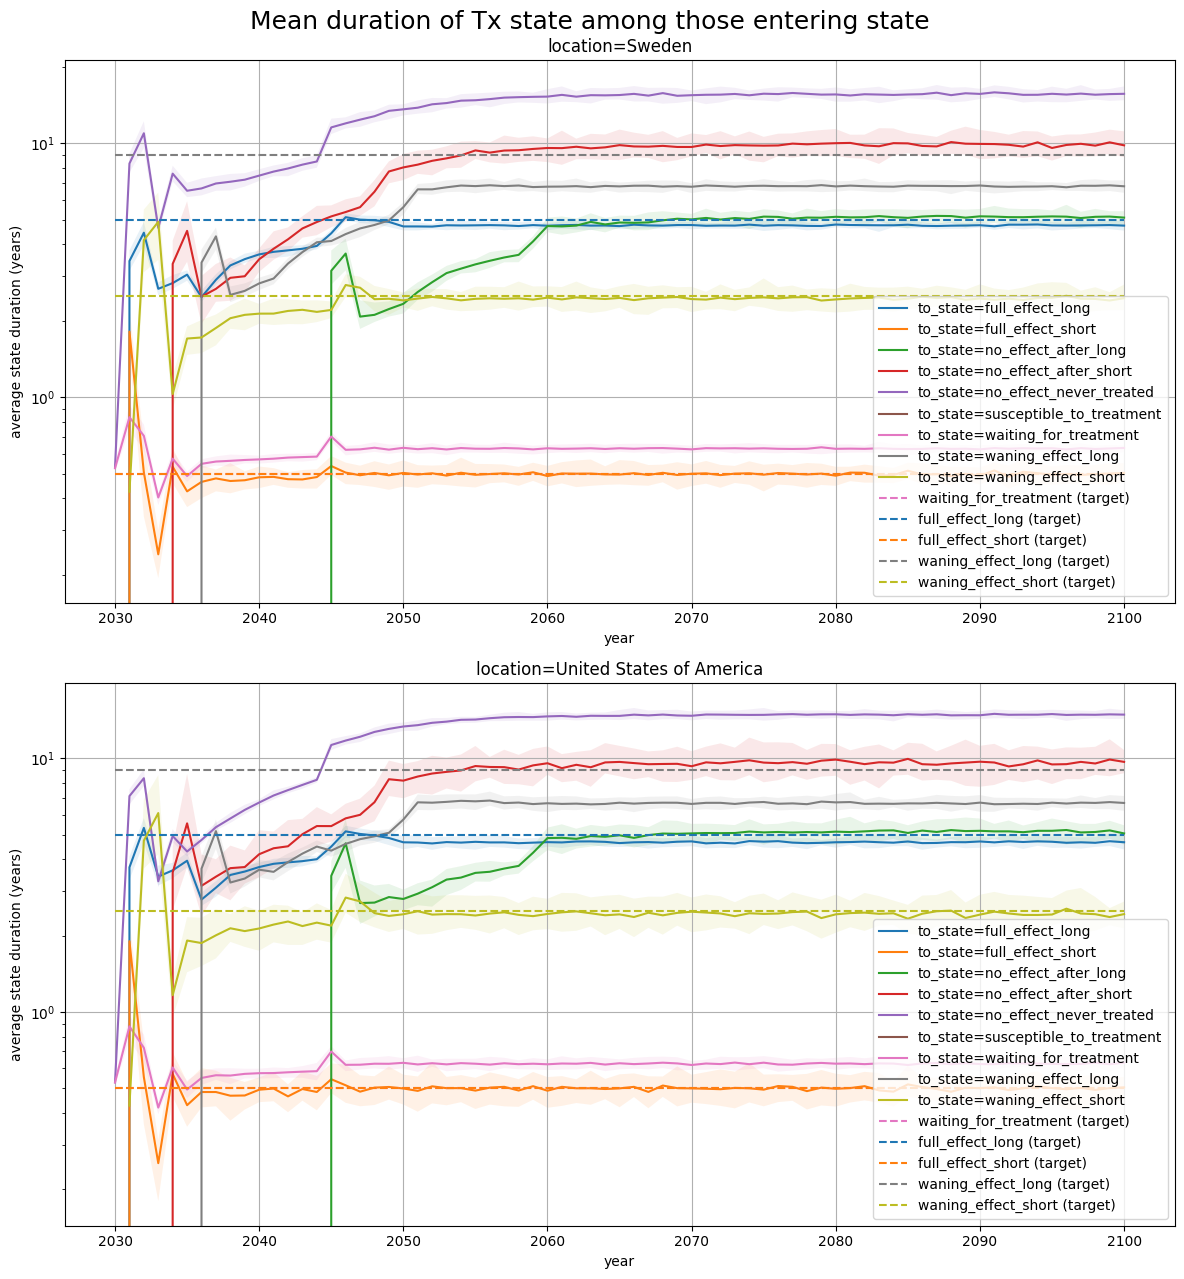

In [68]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

In [69]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

event_year           from_state  input_draw  \
0            2030     full_effect_long           2   
1            2030     full_effect_long           2   
2            2030     full_effect_long          13   
3            2030     full_effect_long          13   
4            2030     full_effect_long          24   
...           ...                  ...         ...   
31945        2100  waning_effect_short         460   
31946        2100  waning_effect_short         480   
31947        2100  waning_effect_short         480   
31948        2100  waning_effect_short         499   
31949        2100  waning_effect_short         499   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                    Sweden       NaN   
1      bbbm_testing_and_treatment  United States of America       NaN   
2      bbbm_testing_and_treatment                    Sweden       NaN   
3      bbbm_testing_and_treatment  United States of America       NaN   
4      bbbm_testing_and_treatment                    Sweden       NaN   
...                           ...                       ...       ...   
31945  bbbm_testing_and_treatment  United States of America  2.799909   
31946  bbbm_testing_and_treatment                    Sweden  2.948655   
31947  bbbm_testing_and_treatment  United States of America  2.817098   
31948  bbbm_testing_and_treatment                    Sweden  2.713103   
31949  bbbm_testing_and_treatment  United States of America  2.998179   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
31945       person_time    transition_count           1  
31946       person_time    transition_count           1  
31947       person_time    transition_count           1  
31948       person_time    transition_count           1  
31949       person_time    transition_count           1  

[31950 rows x 9 columns]

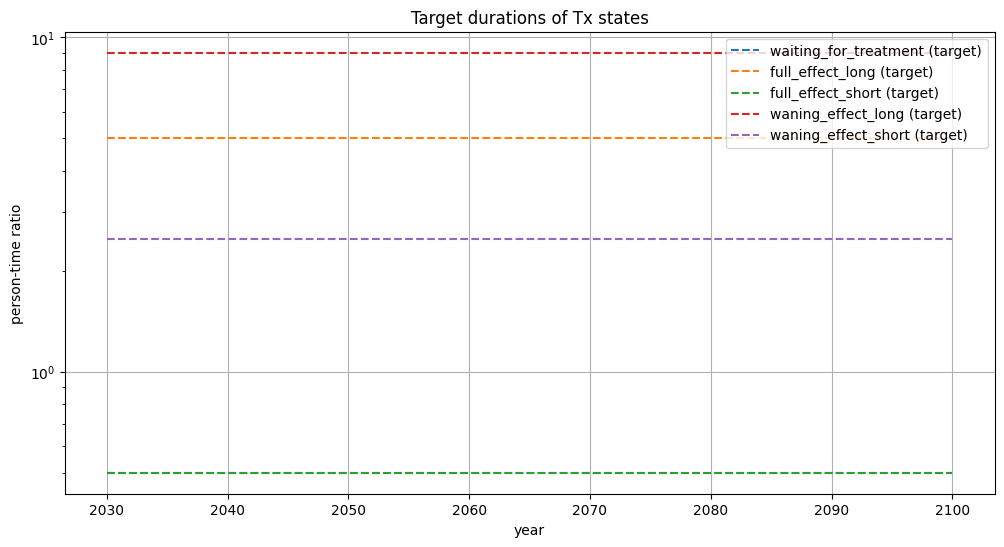

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

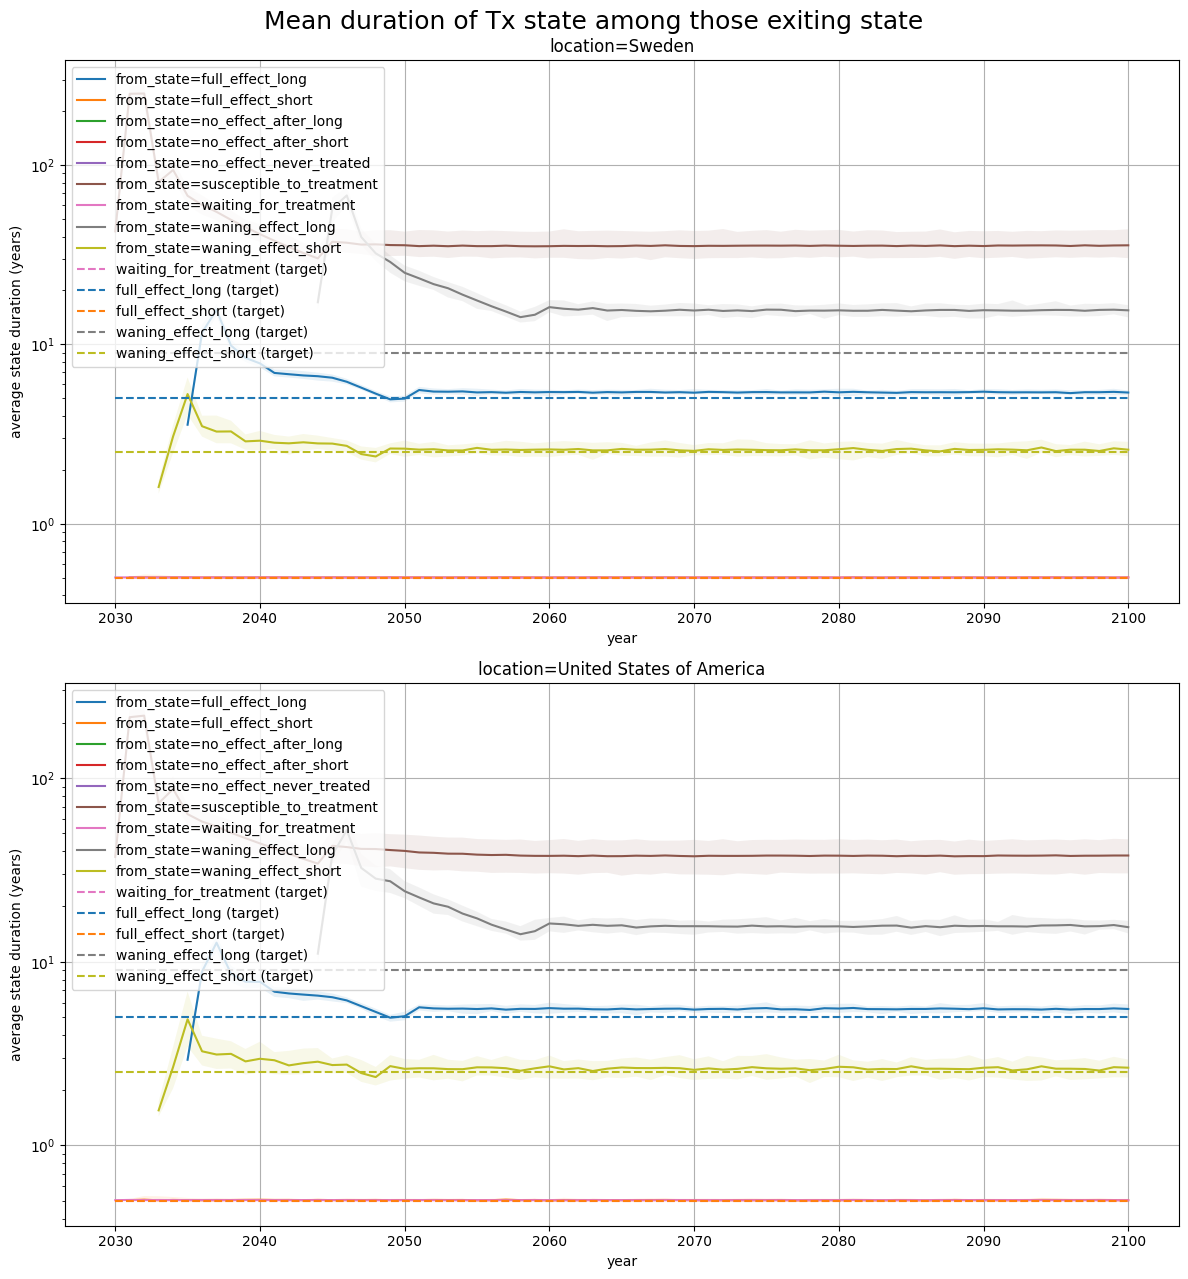

In [71]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [72]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean        6.719965
std         0.219684
min         6.043062
25%         6.568239
50%         6.714394
75%         6.866378
max         7.546177
Name: value, dtype: float64

In [73]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean       15.993862
std         1.730348
min        12.875632
25%        15.047285
50%        15.631653
75%        16.331150
max        25.830048
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [74]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean        4.710695
std         0.121365
min         4.299853
25%         4.636959
50%         4.712848
75%         4.789462
max         5.122229
Name: value, dtype: float64

In [75]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2050").value.describe()

count    2500.000000
mean        5.481453
std         0.150489
min         4.998614
25%         5.377245
50%         5.464388
75%         5.571917
max         6.065123
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [76]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias',
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])


201.574077 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
9598495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
9598499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
9598495  alzheimers_disease_and_other_dementias       cause        2100   
9598496  alzheimers_disease_and_other_dementias       cause        2100   
9598497  alzheimers_disease_and_other_dementias       cause        2100   
9598498  alzheimers_disease_and_other_dementias       cause        2100   
9598499  alzheimers_disease_and_other_dementias       cause        2100   

        input_draw      measure                    scenario     sex  \
0              258  person_time                    baseline  Female   
1              258  person_time                    baseline  Female   
2              258  person_time                    baseline  Female   
3              258  person_time                    baseline  Female   
4              258  person_time                    baseline  Female   
...            ...          ...                         ...     ...   
9598495        446  person_time  bbbm_testing_and_treatment    Male   
9598496        446  person_time  bbbm_testing_and_treatment    Male   
9598497        446  person_time  bbbm_testing_and_treatment    Male   
9598498        446  person_time  bbbm_testing_and_treatment    Male   
9598499        446  person_time  bbbm_testing_and_treatment    Male   

                                     sub_entity                 treatment  \
0        alzheimers_blood_based_biomarker_state  susceptible_to_treatment   
1        alzheimers_blood_based_biomarker_state     waiting_for_treatment   
2        alzheimers_blood_based_biomarker_state          full_effect_long   
3        alzheimers_blood_based_biomarker_state         full_effect_short   
4        alzheimers_blood_based_biomarker_state        waning_effect_long   
...                                         ...                       ...   
9598495                alzheimers_disease_state        waning_effect_long   
9598496                alzheimers_disease_state       waning_effect_short   
9598497                alzheimers_disease_state      no_effect_after_long   
9598498                alzheimers_disease_state     no_effect_after_short   
9598499                alzheimers_disease_state   no_effect_never_treated   

             value                  location  
0         0.000000                    Sweden  
1         0.000000                    Sweden  
2         0.000000                    Sweden  
3         0.000000                    Sweden  
4         0.000000                    Sweden  
...            ...                       ...  
9598495   0.000000  United States of America  
9598496   0.000000  United States of America  
9598497  32.388775  United States of Amer

In [77]:
person_time_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
dtype: object

In [78]:
person_time_cause_states.treatment.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short', 'no_effect_after_long', 'no_effect_after_short', 'no_effect_never_treated']
Categories (9, object): ['full_effect_long', 'full_effect_short', 'no_effect_after_long', 'no_effect_after_short', ..., 'susceptible_to_treatment', 'waiting_for_treatment', 'waning_effect_long', 'waning_effect_short']

In [79]:
person_time_cause_states.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [80]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias',
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Display memory usage of loaded dataframe after adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])
134.384575 MB
1330.997575 MB
140.786901 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
6398995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
6398999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
0        alzheimers_disease_and_other_dementias       cause       2022   
1        alzheimers_disease_and_other_dementias       cause       2022   
2        alzheimers_disease_and_other_dementias       cause       2022   
3        alzheimers_disease_and_other_dementias       cause       2022   
4        alzheimers_disease_and_other_dementias       cause       2022   
...                                         ...         ...        ...   
6398995  alzheimers_disease_and_other_dementias       cause       2100   
6398996  alzheimers_disease_and_other_dementias       cause       2100   
6398997  alzheimers_disease_and_other_dementias       cause       2100   
6398998  alzheimers_disease_and_other_dementias       cause       2100   
6398999  alzheimers_disease_and_other_dementias       cause       2100   

        input_draw           measure                    scenario     sex  \
0              258  transition_count                    baseline  Female   
1              258  transition_count                    baseline  Female   
2              258  transition_count                    baseline  Female   
3              258  transition_count                    baseline  Female   
4              258  transition_count                    baseline  Female   
...            ...               ...                         ...     ...   
6398995        446  transition_count  bbbm_testing_and_treatment    Male   
6398996        446  transition_count  bbbm_testing_and_treatment    Male   
6398997        446  transition_count  bbbm_testing_and_treatment    Male   
6398998        446  transition_count  bbbm_testing_and_treatment    Male   
6398999        446  transition_count  bbbm_testing_and_treatment    Male   

                                                sub_entity  \
0        alzheimers_blood_based_biomarker_state_to_alzh...   
1        alzheimers_blood_based_biomarker_state_to_alzh...   
2        alzheimers_blood_based_biomarker_state_to_alzh...   
3        alzheimers_blood_based_biomarker_state_to_alzh...   
4        alzheimers_blood_based_biomarker_state_to_alzh...   
...                                                    ...   
6398995  alzheimers_mild_cognitive_impairment_state_to_...   
6398996  alzheimers_mild_cognitive_impairment_state_to_...   
6398997  alzheimers_mild_cognitive_impairment_state_to_...   
6398998  alzheimers_mild_cognitive_impairment_state_to_...   
6398999  alzheimers_mild_cognitive_impairment_state_to_...   

                        treatment  value                  location  \
0        susceptible_to_treatment    0.0                    Sweden   
1           waiting_for_treatment    0.0                    Sweden   
2                full_effect_long    0.0                    Sweden   
3               full_effect_short    0.0                    Sweden   
4              waning_effect_long    0.0                    Sweden   
...                           ...    ...                       ...   
6398995        waning_effect_long    0.0  United States of America   
6398996       waning_effect_short   

In [81]:
transition_count_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year       category
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
from_state       category
to_state         category
dtype: object

In [82]:
transition_count_cause_states.from_state.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (2, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']

In [83]:
incidence_rates_by_treatment = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states.rename(columns={'sub_entity': 'from_state'}),
    strata=['event_year', 'from_state', 'treatment'],
    numerator_broadcast='to_state', # doesn't actually broadcast, just records it
    measure='transition_rate',
    dropna=True,
)
incidence_rates_by_treatment

event_year                                  from_state  \
0            2022      alzheimers_blood_based_biomarker_state   
1            2022      alzheimers_blood_based_biomarker_state   
2            2022      alzheimers_blood_based_biomarker_state   
3            2022      alzheimers_blood_based_biomarker_state   
4            2022      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
81535        2100  alzheimers_mild_cognitive_impairment_state   
81536        2100  alzheimers_mild_cognitive_impairment_state   
81537        2100  alzheimers_mild_cognitive_impairment_state   
81538        2100  alzheimers_mild_cognitive_impairment_state   
81539        2100  alzheimers_mild_cognitive_impairment_state   

                      treatment  input_draw                    scenario  \
0      susceptible_to_treatment           2                    baseline   
1      susceptible_to_treatment           2                    baseline   
2      susceptible_to_treatment           2                bbbm_testing   
3      susceptible_to_treatment           2                bbbm_testing   
4      susceptible_to_treatment           2  bbbm_testing_and_treatment   
...                         ...         ...                         ...   
81535       waning_effect_short         460  bbbm_testing_and_treatment   
81536       waning_effect_short         480  bbbm_testing_and_treatment   
81537       waning_effect_short         480  bbbm_testing_and_treatment   
81538       waning_effect_short         499  bbbm_testing_and_treatment   
81539       waning_effect_short         499  bbbm_testing_and_treatment   

                       location                                    to_state  \
0                        Sweden  alzheimers_mild_cognitive_impairment_state   
1      United States of America  alzheimers_mild_cognitive_impairment_state   
2                        Sweden  alzheimers_mild_cognitive_impairment_state   
3      United States of America  alzheimers_mild_cognitive_impairment_state   
4                        Sweden  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
81535  United States of America                    alzheimers_disease_state   
81536                    Sweden                    alzheimers_disease_state   
81537  United States of America                    alzheimers_disease_state   
81538                    Sweden                    alzheimers_disease_state   
81539  United States of America                    alzheimers_disease_state   

          value          measure numerator_measure denominator_measure  \
0      0.142187  transition_rate  transition_count         person_time   
1      0.143482  transition_rate  transition_count         person_time   
2      0.142187  transition_rate  transition_count         person_time   
3      0.143482  transition_rate  transition_count         person_time   
4      0.142187  transition_rate  transition_count         person_time   
...         ...              ...               ...                 ...   
81535  0.225069  transition_rate  transition_count         person_time   
81536  0.213968  transition_rate  transition_count         person_time   
81537  0.240824  transition_rate  transition_count         person_time   
81538  0.191527  transition_rate  transition_count         person_time   
81539  0.167239  transition_rate  transition_count         person_time   

       multiplier  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
81535           1  
81536           1  
81537           1  
81538           1  
81539           1  

[81540 rows x 12 columns]

## Investigate infinite transition rates between disease states

My plotting code below initially failed with `FloatingPointError:
invalid value encountered in subtract` in the `lower` function, due to
infinities in the transition rates data.

According to the engineers, we may be getting 0 person-time in some
strata where counts are nonzero because person-time is recorded at the
beginning of a time step, while transition counts are recorded at the
end. So for example, if someone starts in preclinical, in the "waiting
for treatment" state, then transitions to MCI and to "full effect long"
on the same time step, then they would have their person-time recorded
in the (preclinical, waiting for treatment) stratum, but their disease
transition recorded in the (preclinical- > MCI, full effect long)
stratum.

The engineers said there was a bugfix in model 7.2 that *might* address
this problem, so I'll try this again there...

In [84]:
incidence_rates_by_treatment.value.describe()

count    8.154000e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.425552e-01
50%      1.830997e-01
75%      2.512800e-01
max               inf
Name: value, dtype: float64

In [85]:
inf = np.isinf(incidence_rates_by_treatment.value)
print(inf.sum(), "rows with infinite values")
incidence_rates_by_treatment.loc[inf]#.query("from_state=='alzheimers_blood_based_biomarker_state'")

400 rows with infinite values


event_year                                  from_state  \
2400         2030      alzheimers_blood_based_biomarker_state   
2401         2030      alzheimers_blood_based_biomarker_state   
2402         2030      alzheimers_blood_based_biomarker_state   
2403         2030      alzheimers_blood_based_biomarker_state   
2404         2030      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
16735        2044  alzheimers_mild_cognitive_impairment_state   
16736        2044  alzheimers_mild_cognitive_impairment_state   
16737        2044  alzheimers_mild_cognitive_impairment_state   
16738        2044  alzheimers_mild_cognitive_impairment_state   
16739        2044  alzheimers_mild_cognitive_impairment_state   

                  treatment  input_draw                    scenario  \
2400       full_effect_long           2  bbbm_testing_and_treatment   
2401       full_effect_long           2  bbbm_testing_and_treatment   
2402       full_effect_long          13  bbbm_testing_and_treatment   
2403       full_effect_long          13  bbbm_testing_and_treatment   
2404       full_effect_long          24  bbbm_testing_and_treatment   
...                     ...         ...                         ...   
16735  no_effect_after_long         460  bbbm_testing_and_treatment   
16736  no_effect_after_long         480  bbbm_testing_and_treatment   
16737  no_effect_after_long         480  bbbm_testing_and_treatment   
16738  no_effect_after_long         499  bbbm_testing_and_treatment   
16739  no_effect_after_long         499  bbbm_testing_and_treatment   

                       location                                    to_state  \
2400                     Sweden  alzheimers_mild_cognitive_impairment_state   
2401   United States of America  alzheimers_mild_cognitive_impairment_state   
2402                     Sweden  alzheimers_mild_cognitive_impairment_state   
2403   United States of America  alzheimers_mild_cognitive_impairment_state   
2404                     Sweden  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
16735  United States of America                    alzheimers_disease_state   
16736                    Sweden                    alzheimers_disease_state   
16737  United States of America                    alzheimers_disease_state   
16738                    Sweden                    alzheimers_disease_state   
16739  United States of America                    alzheimers_disease_state   

       value          measure numerator_measure denominator_measure  \
2400     inf  transition_rate  transition_count         person_time   
2401     inf  transition_rate  transition_count         person_time   
2402     inf  transition_rate  transition_count         person_time   
2403     inf  transition_rate  transition_count         person_time   
2404     inf  transition_rate  transition_count         person_time   
...      ...              ...               ...                 ...   
16735    inf  transition_rate  transition_count         person_time   
16736    inf  transition_rate  transition_count         person_time   
16737    inf  transition_rate  transition_count         person_time   
16738    inf  transition_rate  transition_count         person_time   
16739    inf  transition_rate  transition_count         person_time   

       multiplier  
2400            1  
2401            1  
2402            1  
2403            1  
2404            1  
...           ...  
16735           1  
16736           1  
16737           1  
16738           1  
16739           1  

[400 rows x 12 columns]

In [86]:
transition_count_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and from_state=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

age_group                                      artifact_path  \
3046754  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
3046772  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
3260054  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
3260072  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
3473354  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3473372  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3686654  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3686672  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
3899954  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
3899972  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
4113254  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
4113272  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
4326554  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4326572  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4539854  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4539872  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
4753154  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
4753172  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
4966454  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
4966472  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
3046754  alzheimers_disease_and_other_dementias       cause       2044   
3046772  alzheimers_disease_and_other_dementias       cause       2044   
3260054  alzheimers_disease_and_other_dementias       cause       2044   
3260072  alzheimers_disease_and_other_dementias       cause       2044   
3473354  alzheimers_disease_and_other_dementias       cause       2044   
3473372  alzheimers_disease_and_other_dementias       cause       2044   
3686654  alzheimers_disease_and_other_dementias       cause       2044   
3686672  alzheimers_disease_and_other_dementias       cause       2044   
3899954  alzheimers_disease_and_other_dementias       cause       2044   
3899972  alzheimers_disease_and_other_dementias       cause       2044   
4113254  alzheimers_disease_and_other_dementias       cause       2044   
4113272  alzheimers_disease_and_other_dementias       cause       2044   
4326554  alzheimers_disease_and_other_dementias       cause       2044   
4326572  alzheimers_disease_and_other_dementias       cause       2044   
4539854  alzheimers_disease_and_other_dementias       cause       2044   
4539872  alzheimers_disease_and_other_dementias       cause       2044   
4753154  alzheimers_disease_and_other_dementias       cause       2044   
4753172  alzheimers_disease_and_other_dementias       cause       2044   
4966454  alzheimers_disease_and_other_dementias       cause       2044   
4966472  alzheimers_disease_and_other_dementias       cause       2044   

        input_draw           measure                    scenario     sex  \
3046754        499  transition_count  bbbm_testing_and_treatment  Female   
3046772        499  transition_count  bbbm_testing_and_treatment    Male   
3260054        499  transition_count  bbbm_testing_and_treatment  Female   
3260072        499  transition_count  bbbm_testing_and_treatment    Male   
3473354        499  transition_count  bbbm_testing_and_treatment  Female   
3473372        499  transition_count  bbbm_testing_and_treatment    Male   
3686654        499  transition_count  bbbm_testing_and_treatment  Female   
3686672        499  transition_count  bbbm_testing_and_treatment    Male   
3899954        499  transition_count  bbbm_testing_and_treatment  Female   
3899972        499  transition_count  bbbm_testing_and_treatment    Male   
4113254        499  transition_count  bbbm_testing_and_treatment  Female   
4113272        499  transiti

In [87]:
person_time_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2030 and sub_entity=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==2 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

age_group                                      artifact_path  \
4513106  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
4513133  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
4833056  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
4833083  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
5153006  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5153033  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5472956  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5472983  65_to_69  /mnt/team/simulation_science/pub/models/vivari...   
5792906  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
5792933  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
6112856  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
6112883  70_to_74  /mnt/team/simulation_science/pub/models/vivari...   
6432806  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
6432833  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
6752756  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
6752783  75_to_79  /mnt/team/simulation_science/pub/models/vivari...   
7072706  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
7072733  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
7392656  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   
7392683  80_to_84  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
4513106  alzheimers_disease_and_other_dementias       cause        2030   
4513133  alzheimers_disease_and_other_dementias       cause        2030   
4833056  alzheimers_disease_and_other_dementias       cause        2030   
4833083  alzheimers_disease_and_other_dementias       cause        2030   
5153006  alzheimers_disease_and_other_dementias       cause        2030   
5153033  alzheimers_disease_and_other_dementias       cause        2030   
5472956  alzheimers_disease_and_other_dementias       cause        2030   
5472983  alzheimers_disease_and_other_dementias       cause        2030   
5792906  alzheimers_disease_and_other_dementias       cause        2030   
5792933  alzheimers_disease_and_other_dementias       cause        2030   
6112856  alzheimers_disease_and_other_dementias       cause        2030   
6112883  alzheimers_disease_and_other_dementias       cause        2030   
6432806  alzheimers_disease_and_other_dementias       cause        2030   
6432833  alzheimers_disease_and_other_dementias       cause        2030   
6752756  alzheimers_disease_and_other_dementias       cause        2030   
6752783  alzheimers_disease_and_other_dementias       cause        2030   
7072706  alzheimers_disease_and_other_dementias       cause        2030   
7072733  alzheimers_disease_and_other_dementias       cause        2030   
7392656  alzheimers_disease_and_other_dementias       cause        2030   
7392683  alzheimers_disease_and_other_dementias       cause        2030   

        input_draw      measure                    scenario     sex  \
4513106          2  person_time  bbbm_testing_and_treatment  Female   
4513133          2  person_time  bbbm_testing_and_treatment    Male   
4833056          2  person_time  bbbm_testing_and_treatment  Female   
4833083          2  person_time  bbbm_testing_and_treatment    Male   
5153006          2  person_time  bbbm_testing_and_treatment  Female   
5153033          2  person_time  bbbm_testing_and_treatment    Male   
5472956          2  person_time  bbbm_testing_and_treatment  Female   
5472983          2  person_time  bbbm_testing_and_treatment    Male   
5792906          2  person_time  bbbm_testing_and_treatment  Female   
5792933          2  person_time  bbbm_testing_and_treatment    Male   
6112856          2  person_time  bbbm_testing_and_treatment  Female   
6112883          2  person_time  bbbm_testing_and_treatment    Male

## Plot disease transition rates stratified by treatment status, filtering out $\infty$

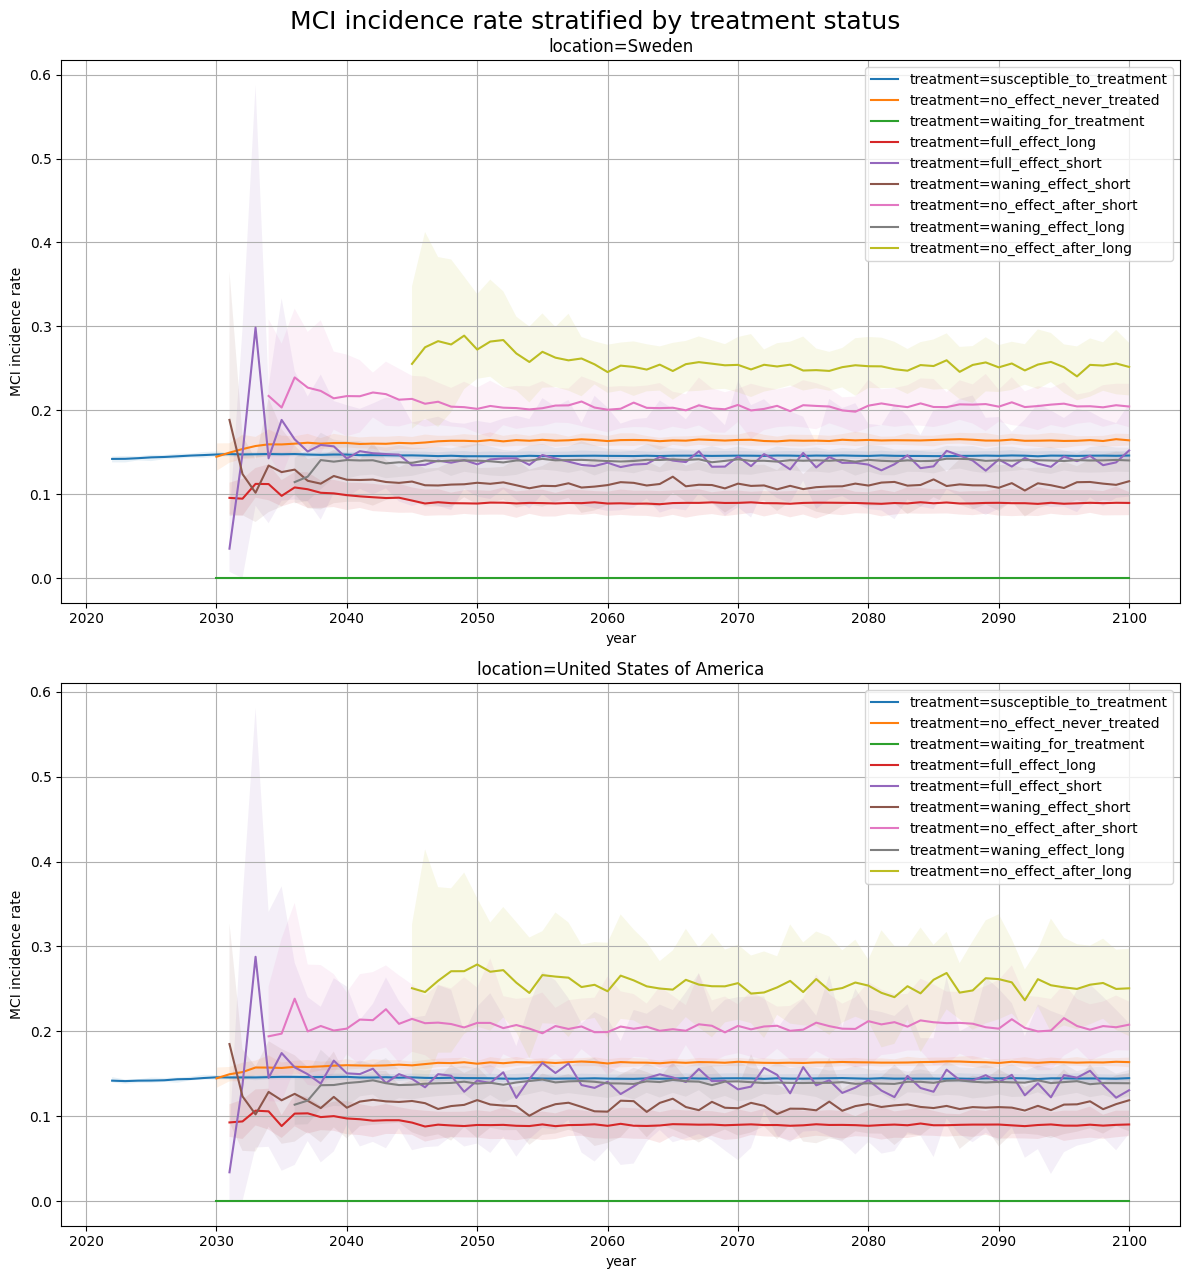

In [88]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_blood_based_biomarker_state'"),
    'treatment',
    'location',
    ylabel='MCI incidence rate',
    suptitle='MCI incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

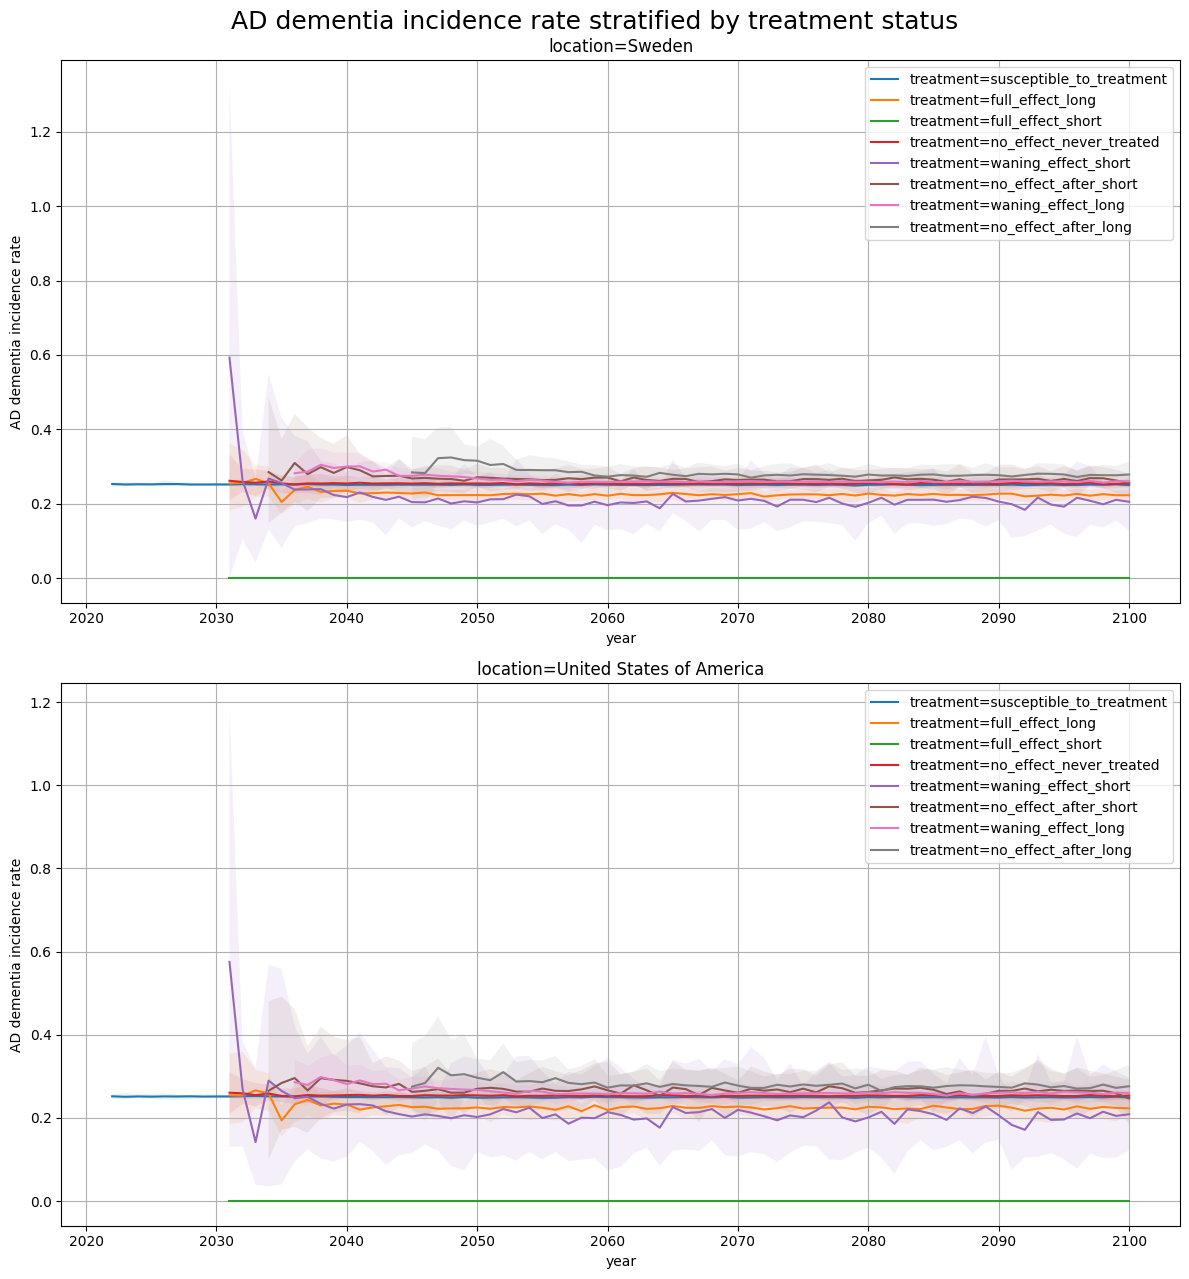

In [89]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_mild_cognitive_impairment_state'"),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate',
    suptitle='AD dementia incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

## Compute hazard ratio

In [90]:
hazard_ratio = ops.ratio(
    incidence_rates_by_treatment,
    incidence_rates_by_treatment.query("treatment=='susceptible_to_treatment'"),
    strata=['event_year', 'from_state'],
    numerator_broadcast=['treatment'],
    # prefilter_query="from_state=='alzheimers_blood_based_biomarker_state'",
)
hazard_ratio

event_year                                  from_state  input_draw  \
0            2022      alzheimers_blood_based_biomarker_state           2   
1            2022      alzheimers_blood_based_biomarker_state           2   
2            2022      alzheimers_blood_based_biomarker_state           2   
3            2022      alzheimers_blood_based_biomarker_state           2   
4            2022      alzheimers_blood_based_biomarker_state           2   
...           ...                                         ...         ...   
81535        2100  alzheimers_mild_cognitive_impairment_state         499   
81536        2100  alzheimers_mild_cognitive_impairment_state         499   
81537        2100  alzheimers_mild_cognitive_impairment_state         499   
81538        2100  alzheimers_mild_cognitive_impairment_state         499   
81539        2100  alzheimers_mild_cognitive_impairment_state         499   

                         scenario                  location  \
0                        baseline                    Sweden   
1                        baseline  United States of America   
2                    bbbm_testing                    Sweden   
3                    bbbm_testing  United States of America   
4      bbbm_testing_and_treatment                    Sweden   
...                           ...                       ...   
81535  bbbm_testing_and_treatment  United States of America   
81536  bbbm_testing_and_treatment  United States of America   
81537  bbbm_testing_and_treatment  United States of America   
81538  bbbm_testing_and_treatment  United States of America   
81539  bbbm_testing_and_treatment  United States of America   

                      treatment     value numerator_measure  \
0      susceptible_to_treatment  1.000000   transition_rate   
1      susceptible_to_treatment  1.000000   transition_rate   
2      susceptible_to_treatment  1.000000   transition_rate   
3      susceptible_to_treatment  1.000000   transition_rate   
4      susceptible_to_treatment  1.000000   transition_rate   
...                         ...       ...               ...   
81535     no_effect_after_short  1.010046   transition_rate   
81536   no_effect_never_treated  0.999282   transition_rate   
81537  susceptible_to_treatment  1.000000   transition_rate   
81538        waning_effect_long  1.059839   transition_rate   
81539       waning_effect_short  0.670285   transition_rate   

      denominator_measure  multiplier  
0         transition_rate           1  
1         transition_rate           1  
2         transition_rate           1  
3         transition_rate           1  
4         transition_rate           1  
...                   ...         ...  
81535     transition_rate           1  
81536     transition_rate           1  
81537     transition_rate           1  
81538     transition_rate           1  
81539     transition_rate           1  

[81540 rows x 10 columns]

In [91]:
hazard_ratio.value.describe()

count    8.154000e+04
mean              inf
std               NaN
min      0.000000e+00
25%      9.144363e-01
50%      1.000000e+00
75%      1.069289e+00
max               inf
Name: value, dtype: float64

In [92]:
inf_ratio = np.isinf(hazard_ratio.value)
print(inf_ratio.sum(), "rows with infinite values")

400 rows with infinite values


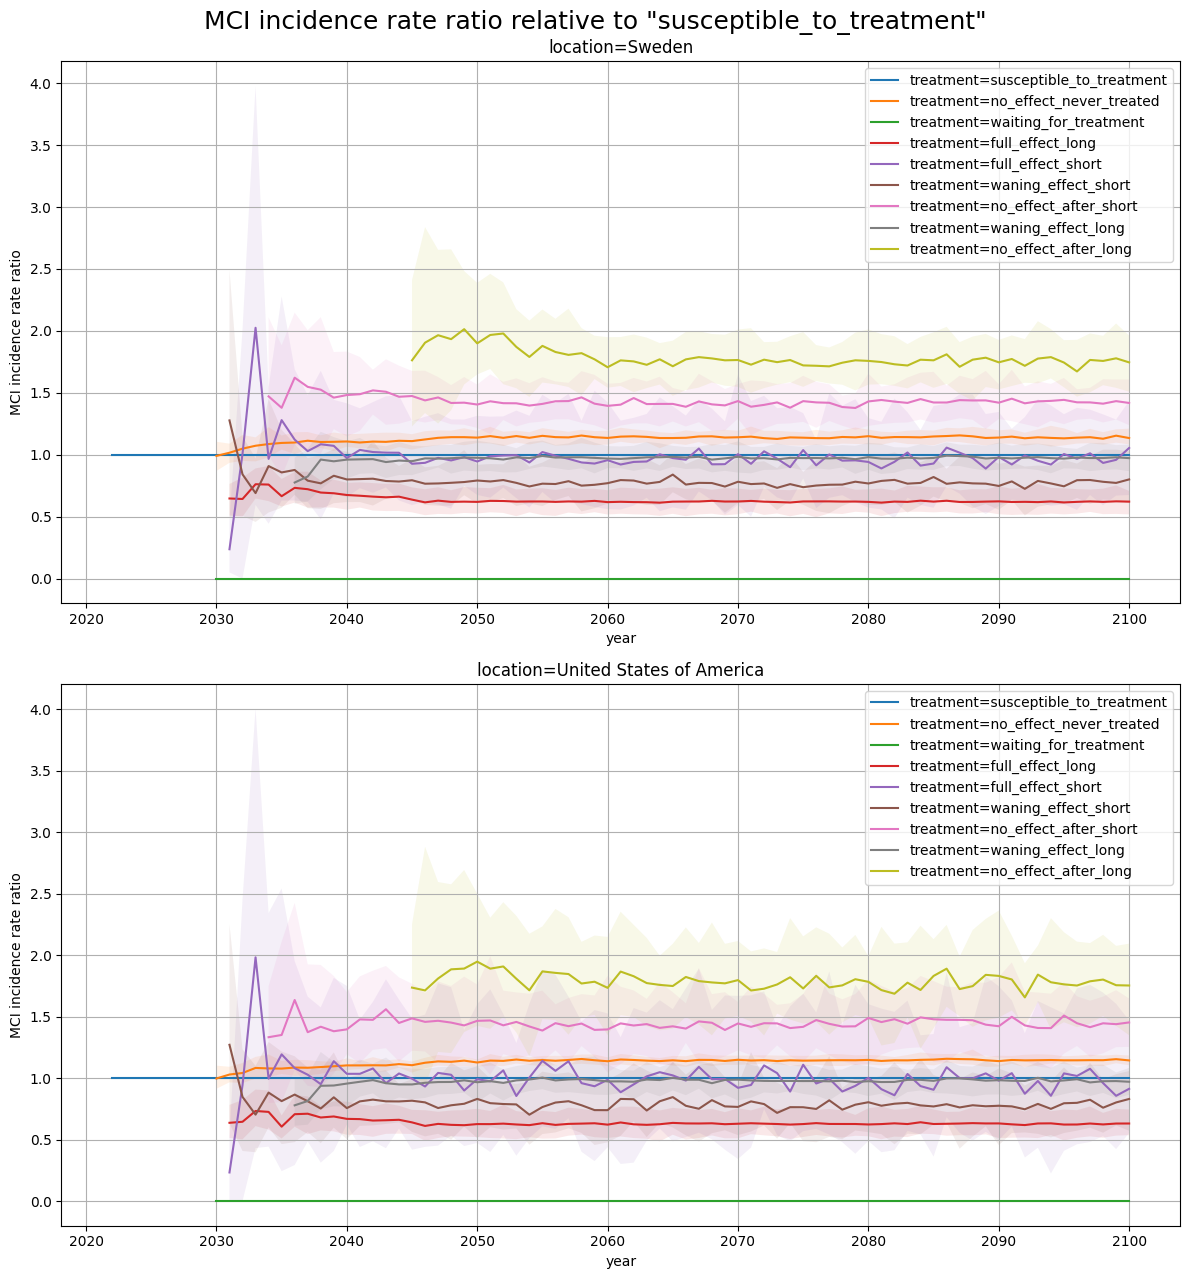

In [93]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment'"# and event_year > 2035"
        " and from_state=='alzheimers_blood_based_biomarker_state'"
        ),
    'treatment',
    'location',
    ylabel='MCI incidence rate ratio',
    suptitle='MCI incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

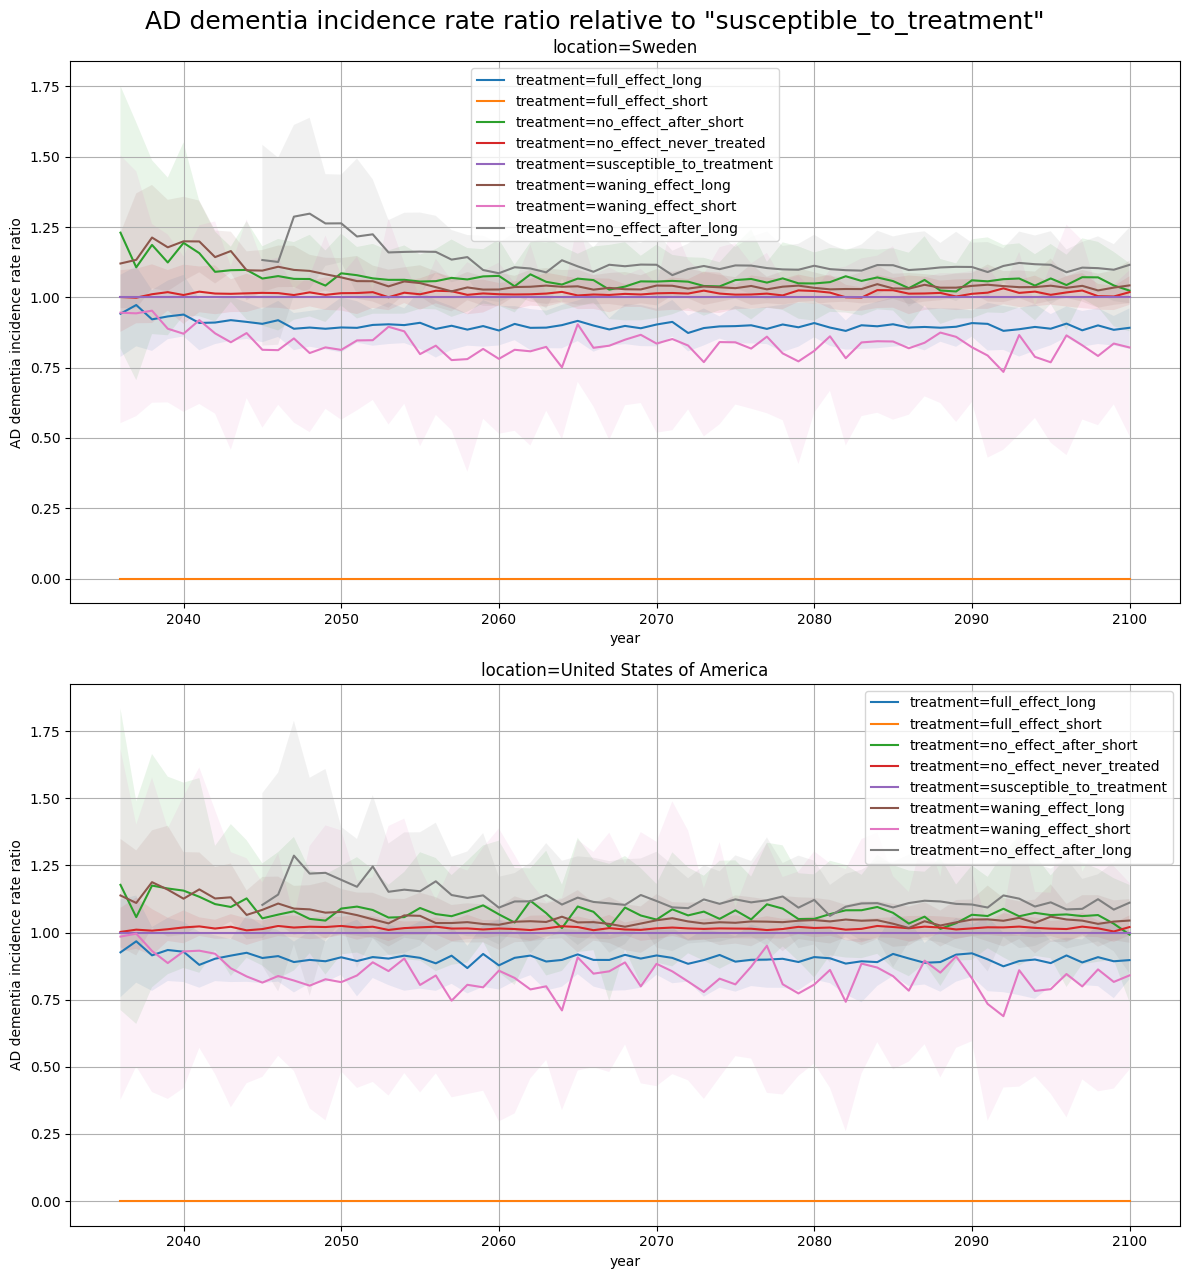

In [94]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment' and event_year > 2035"
        " and from_state=='alzheimers_mild_cognitive_impairment_state'"
        ),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate ratio',
    suptitle='AD dementia incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

# Results!

# Load deaths and plot averted deaths by scenario

In [95]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])


13.513252 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
710995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        258  deaths   
1       alzheimers_disease_state       cause        2022        258  deaths   
2       alzheimers_disease_state       cause        2022        258  deaths   
3       alzheimers_disease_state       cause        2022        258  deaths   
4       alzheimers_disease_state       cause        2022        258  deaths   
...                          ...         ...         ...        ...     ...   
710995              other_causes       cause        2100        446  deaths   
710996              other_causes       cause        2100        446  deaths   
710997              other_causes       cause        2100        446  deaths   
710998              other_causes       cause        2100        446  deaths   
710999              other_causes       cause        2100        446  deaths   

                          scenario     sex   value                  location  
0                         baseline  Female     0.0                    Sweden  
1                         baseline    Male     0.0                    Sweden  
2                     bbbm_testing  Female     0.0                    Sweden  
3                     bbbm_testing    Male     0.0                    Sweden  
4       bbbm_testing_and_treatment  Female     0.0                    Sweden  
...                            ...     ...     ...                       ...  
710995                    baseline    Male   538.0  United States of America  
710996                bbbm_testing  Female  1248.0  United States of America  
710997                bbbm_testing    Male   538.0  United States of America  
710998  bbbm_testing_and_treatment  Female  1254.0  United States of America  
710999  bbbm_testing_and_treatment    Male   540.0  United States of America  

[711000 rows x 11 columns]

In [96]:
# NOTE: I had to rework some code in my vph_output.operators.difference
# function to prevent this code from converting Categoricals back to
# strings and making the memory explode...
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

13.513252 MB measure
6.40312 MB minuend
12.80212 MB subtrahend
4.273424 MB minuend re-indexed
8.539424 MB subtrahend re-indexed
8.539484 MB difference
11.854252 MB difference with reset index
12.328577 MB final difference
12.328577 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
473995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        258  deaths   
1       alzheimers_disease_state       cause        2022        258  deaths   
2       alzheimers_disease_state       cause        2022        258  deaths   
3       alzheimers_disease_state       cause        2022        258  deaths   
4       alzheimers_disease_state       cause        2022        273  deaths   
...                          ...         ...         ...        ...     ...   
473995              other_causes       cause        2100        199  deaths   
473996              other_causes       cause        2100        446  deaths   
473997              other_causes       cause        2100        446  deaths   
473998              other_causes       cause        2100        446  deaths   
473999              other_causes       cause        2100        446  deaths   

           sex                  location                    scenario  \
0       Female                    Sweden                bbbm_testing   
1         Male                    Sweden                bbbm_testing   
2       Female                    Sweden  bbbm_testing_and_treatment   
3         Male                    Sweden  bbbm_testing_and_treatment   
4       Female                    Sweden                bbbm_testing   
...        ...                       ...                         ...   
473995    Male  United States of America  bbbm_testing_and_treatment   
473996  Female  United States of America                bbbm_testing   
473997    Male  United States of America                bbbm_testing   
473998  Female  United States of America  bbbm_testing_and_treatment   
473999    Male  United States of America  bbbm_testing_and_treatment   

       subtracted_from  value  
0             baseline    0.0  
1             baseline    0.0  
2             baseline    0.0  
3             baseline    0.0  
4             baseline    0.0  
...                ...    ...  
473995        baseline   -6.0  
473996        baseline    0.0  
473997        baseline    0.0  
473998        baseline   -6.0  
473999        baseline   -2.0  

[474000 rows x 12 columns]

In [97]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474000 entries, 0 to 473999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        474000 non-null  category
 1   artifact_path    474000 non-null  category
 2   entity           474000 non-null  category
 3   entity_type      474000 non-null  category
 4   event_year       474000 non-null  int64   
 5   input_draw       474000 non-null  category
 6   measure          474000 non-null  category
 7   sex              474000 non-null  category
 8   location         474000 non-null  category
 9   scenario         474000 non-null  category
 10  subtracted_from  474000 non-null  category
 11  value            474000 non-null  float64 
dtypes: category(10), float64(1), int64(1)
memory usage: 11.8 MB


In [98]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [99]:
averted_deaths.index.memory_usage(deep=True)

132

In [100]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [101]:
averted_deaths.value.describe()

count    474000.000000
mean          0.160175
std           7.626224
min        -102.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         108.000000
Name: value, dtype: float64

In [102]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

12.328577 MB


In [103]:
# FIXME: Wait, to get percent deaths averted, do I want to be dividing
# by deaths in the intervention scenarios (like I do here), or should I
# be dividing by deaths in the *baseline* scenario? Probably the
# latter...
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

12.328577 MB
5.308873 MB


entity age_group  event_year input_draw  \
0       alzheimers_disease_state  40_to_44        2026        265   
1       alzheimers_disease_state  40_to_44        2026        265   
2       alzheimers_disease_state  40_to_44        2026        265   
3       alzheimers_disease_state  40_to_44        2026        265   
4       alzheimers_disease_state  40_to_44        2026        356   
...                          ...       ...         ...        ...   
171133              other_causes   95_plus        2100        199   
171134              other_causes   95_plus        2100        446   
171135              other_causes   95_plus        2100        446   
171136              other_causes   95_plus        2100        446   
171137              other_causes   95_plus        2100        446   

                          scenario                  location     value  \
0                     bbbm_testing                    Sweden  0.000000   
1                     bbbm_testing  United States of America  0.000000   
2       bbbm_testing_and_treatment                    Sweden  0.000000   
3       bbbm_testing_and_treatment  United States of America  0.000000   
4                     bbbm_testing  United States of America  0.000000   
...                            ...                       ...       ...   
171133  bbbm_testing_and_treatment  United States of America -0.768246   
171134                bbbm_testing                    Sweden  0.000000   
171135                bbbm_testing  United States of America  0.000000   
171136  bbbm_testing_and_treatment                    Sweden -0.908540   
171137  bbbm_testing_and_treatment  United States of America -0.445931   

       numerator_measure denominator_measure  multiplier  
0                 deaths              deaths         100  
1                 deaths              deaths         100  
2                 deaths              deaths         100  
3                 deaths              deaths         100  
4                 deaths              deaths         100  
...                  ...                 ...         ...  
171133            deaths              deaths         100  
171134            deaths              deaths         100  
171135            deaths              deaths         100  
171136            deaths              deaths         100  
171137            deaths              deaths         100  

[171138 rows x 10 columns]

In [104]:
averted_deaths_pct.memory_usage(deep=True)

Index                      132
entity                  171396
age_group               172668
event_year             1369104
input_draw              171894
scenario                171463
location                171390
value                  1369104
numerator_measure       171309
denominator_measure     171309
multiplier             1369104
dtype: int64

In [105]:
ops.stratify(averted_deaths, 'event_year')

event_year input_draw                    scenario  \
0           2022        258                bbbm_testing   
1           2022        258                bbbm_testing   
2           2022        258  bbbm_testing_and_treatment   
3           2022        258  bbbm_testing_and_treatment   
4           2022        273                bbbm_testing   
...          ...        ...                         ...   
7895        2100        199  bbbm_testing_and_treatment   
7896        2100        446                bbbm_testing   
7897        2100        446                bbbm_testing   
7898        2100        446  bbbm_testing_and_treatment   
7899        2100        446  bbbm_testing_and_treatment   

                      location  value  
0                       Sweden    0.0  
1     United States of America    0.0  
2                       Sweden    0.0  
3     United States of America    0.0  
4                       Sweden    0.0  
...                        ...    ...  
7895  United States of America   24.0  
7896                    Sweden    0.0  
7897  United States of America    0.0  
7898                    Sweden   12.0  
7899  United States of America    4.0  

[7900 rows x 5 columns]

In [106]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [107]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)
f(a=5, b=7)
f()

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}
5 () {'b': 7}
None () {}


In [108]:
f(2)

2 () {}


# Draw results plots

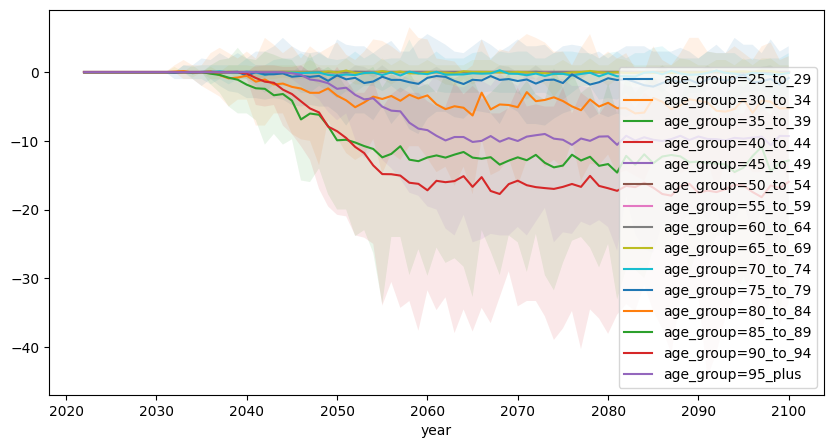

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()


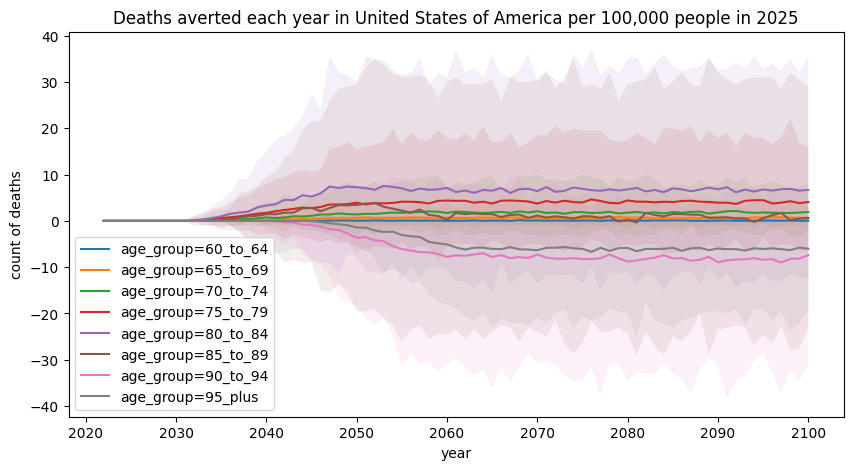

In [110]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

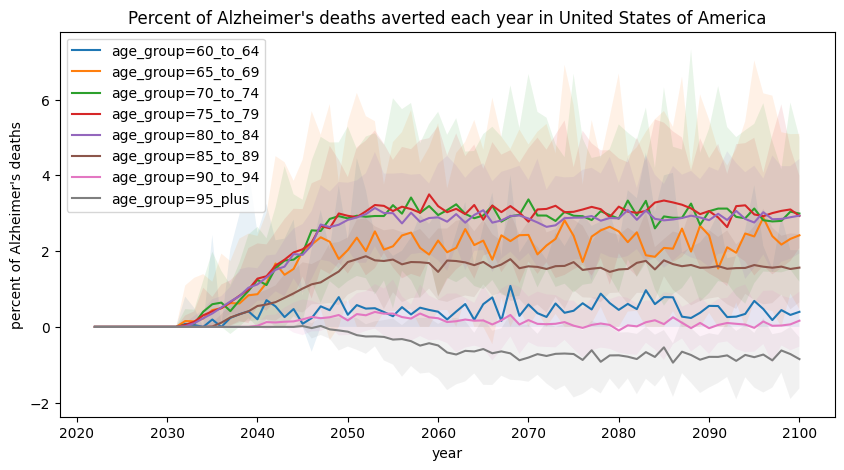

In [111]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [112]:
deaths.scenario.unique()

['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

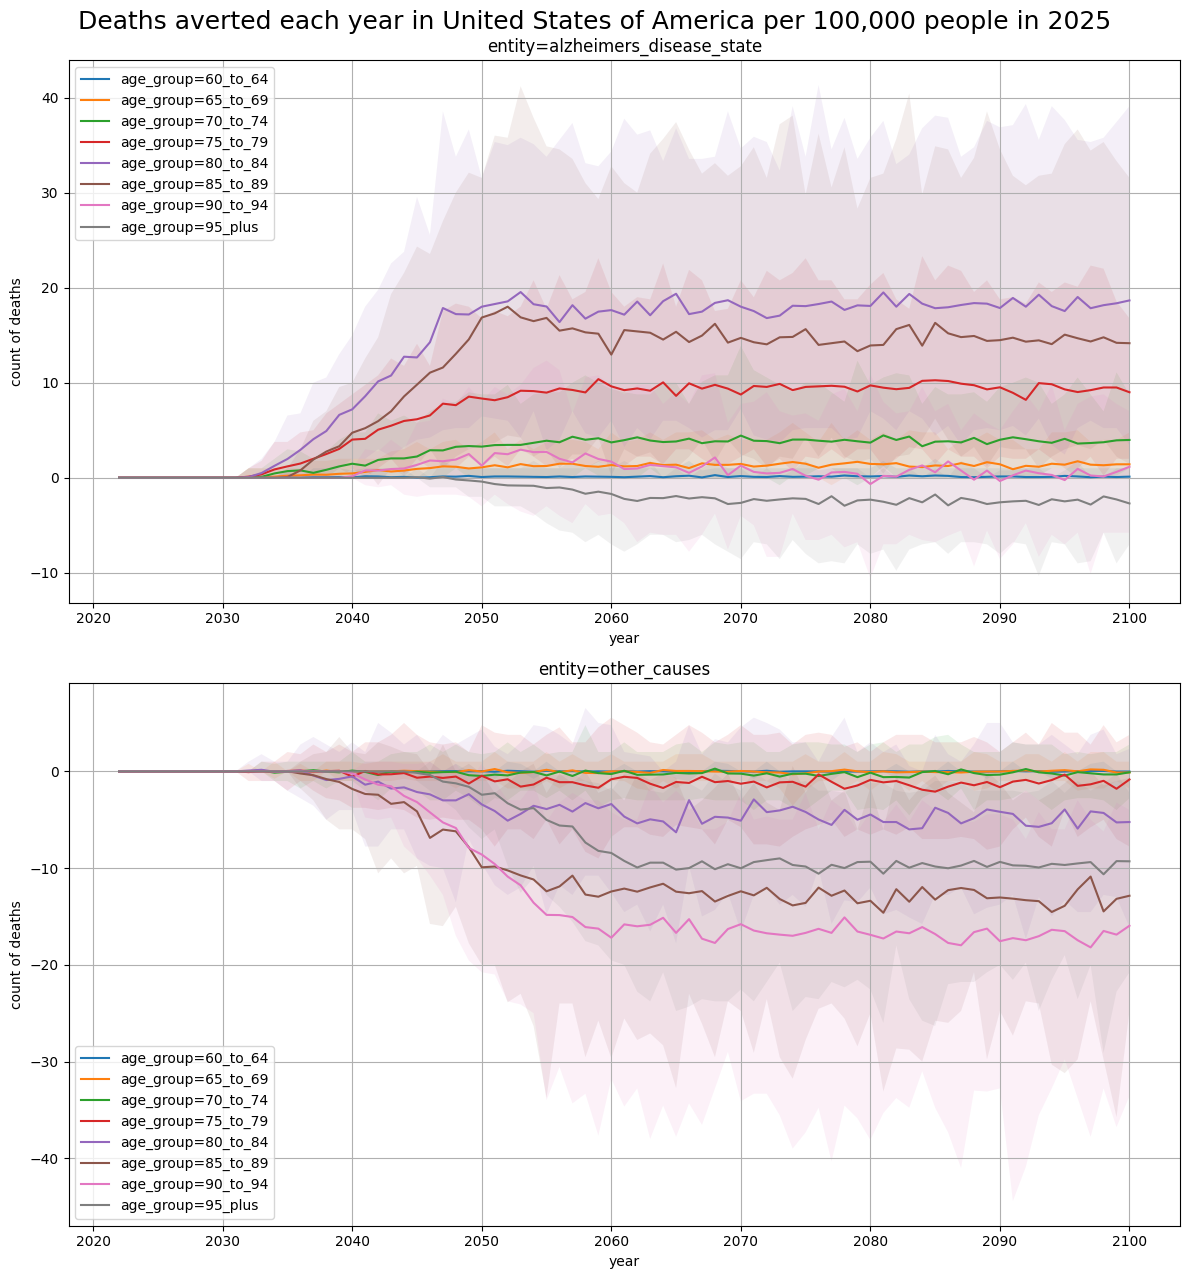

In [113]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Absolute reductions in AD deaths for all countries

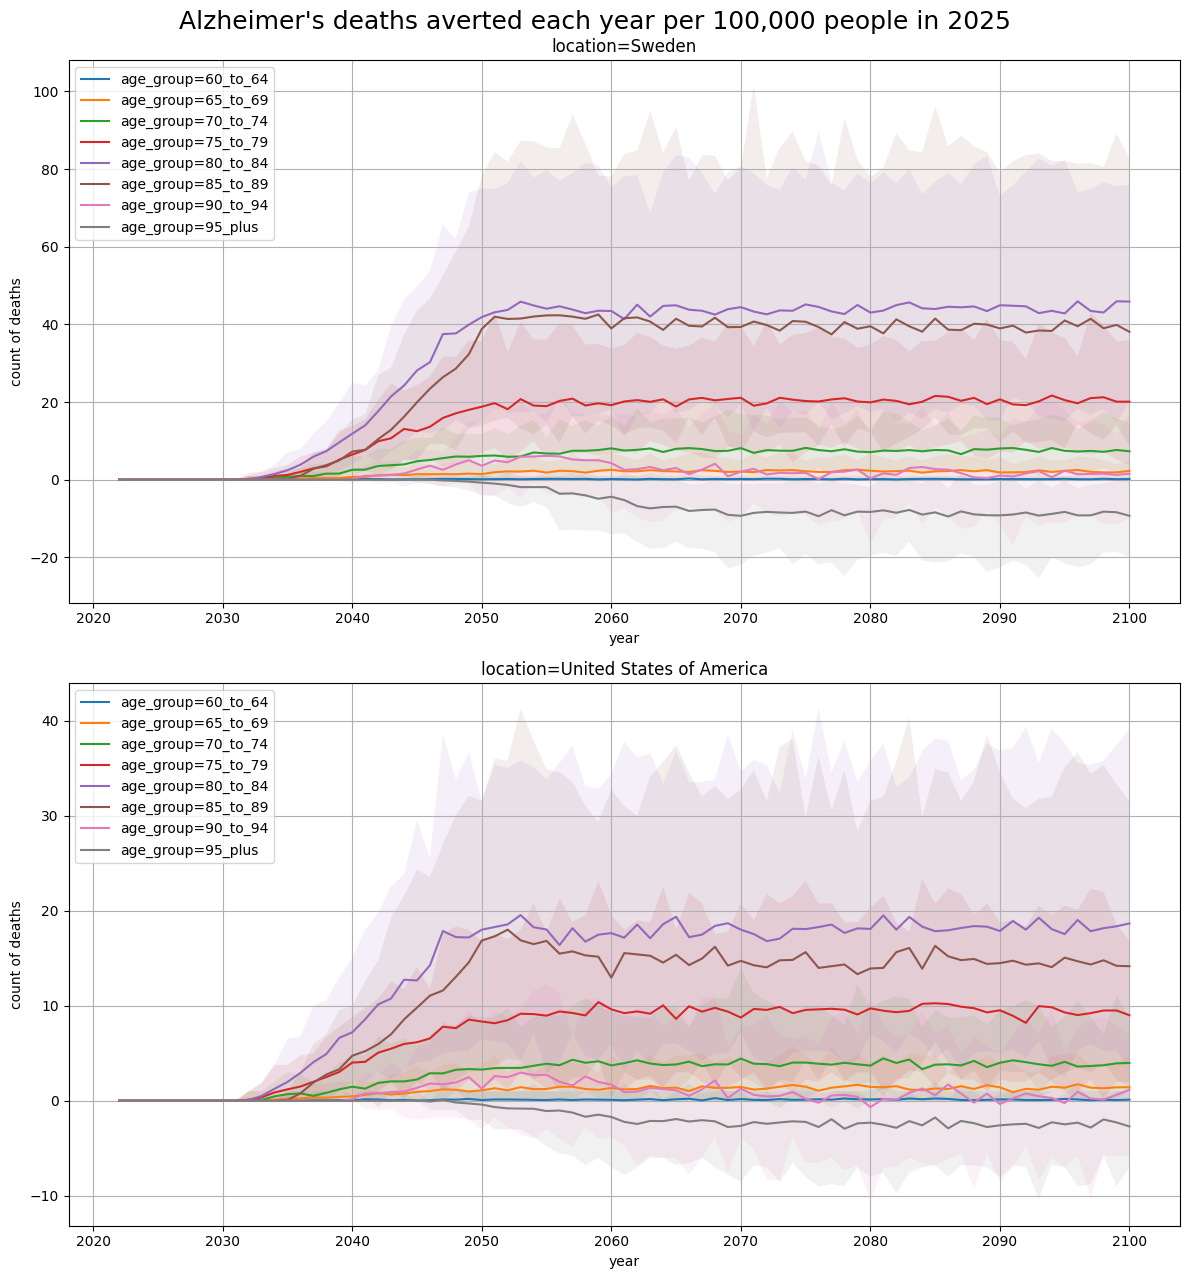

In [114]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

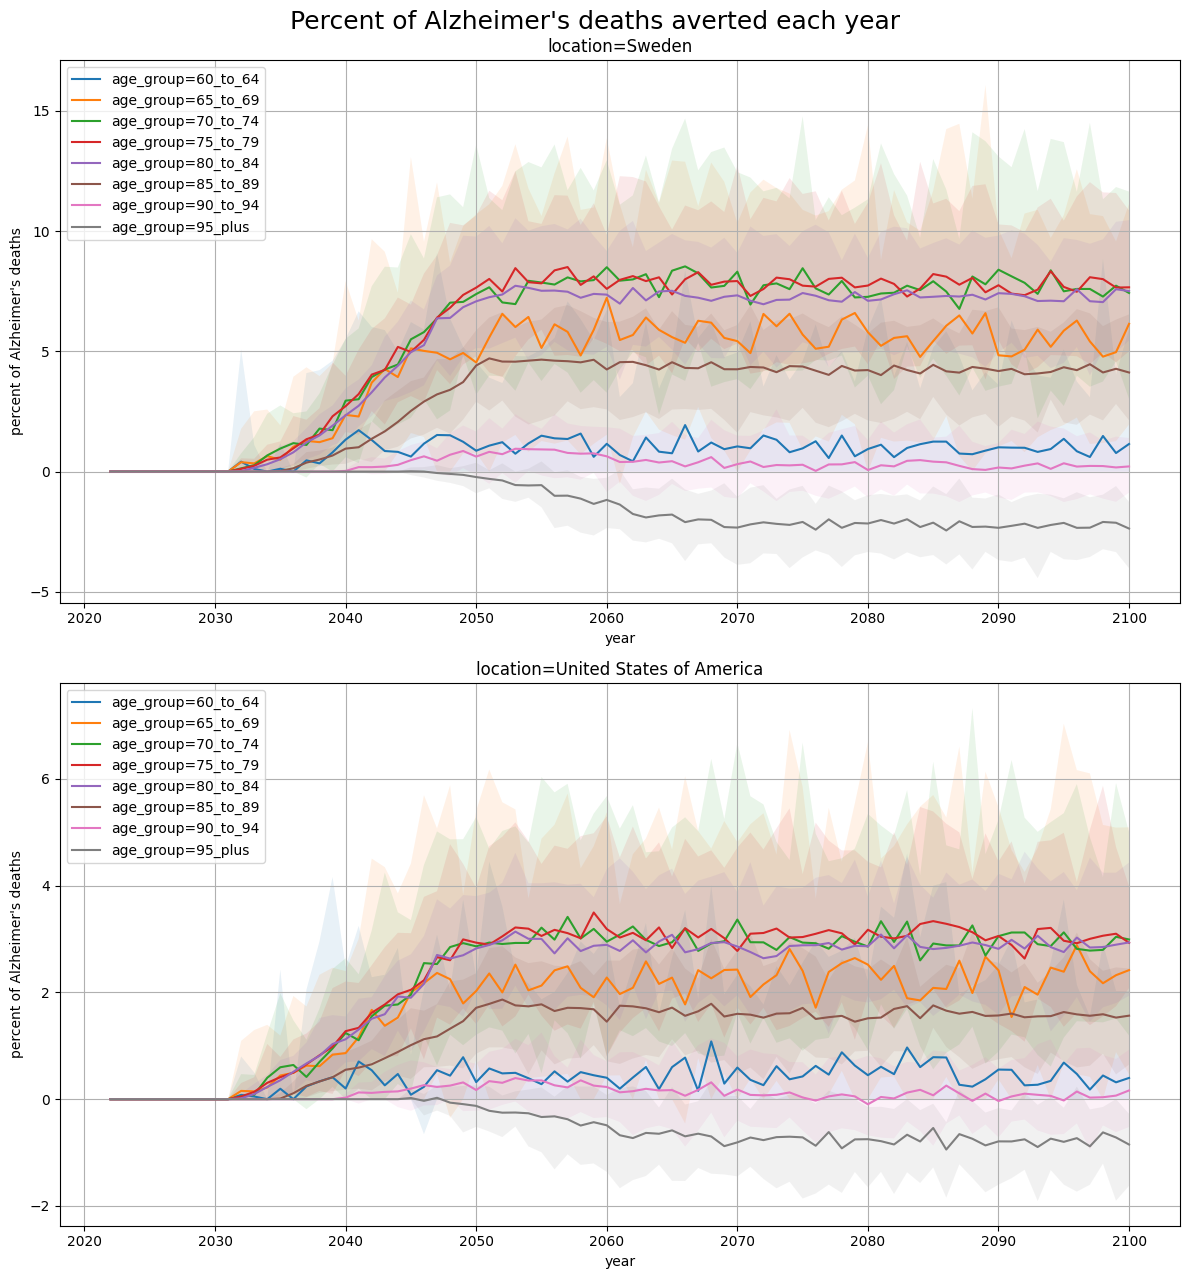

In [115]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Load YLLs and plot averted YLLs

In [116]:
ylls = load_sim_output('ylls')
print_memory_usage(ylls)
ylls

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])


13.51325 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
710995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
710999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        258    ylls   
1       alzheimers_disease_state       cause        2022        258    ylls   
2       alzheimers_disease_state       cause        2022        258    ylls   
3       alzheimers_disease_state       cause        2022        258    ylls   
4       alzheimers_disease_state       cause        2022        258    ylls   
...                          ...         ...         ...        ...     ...   
710995              other_causes       cause        2100        446    ylls   
710996              other_causes       cause        2100        446    ylls   
710997              other_causes       cause        2100        446    ylls   
710998              other_causes       cause        2100        446    ylls   
710999              other_causes       cause        2100        446    ylls   

                          scenario     sex         value  \
0                         baseline  Female      0.000000   
1                         baseline    Male      0.000000   
2                     bbbm_testing  Female      0.000000   
3                     bbbm_testing    Male      0.000000   
4       bbbm_testing_and_treatment  Female      0.000000   
...                            ...     ...           ...   
710995                    baseline    Male   4400.807298   
710996                bbbm_testing  Female  10188.139856   
710997                bbbm_testing    Male   4400.807298   
710998  bbbm_testing_and_treatment  Female  10237.375940   
710999  bbbm_testing_and_treatment    Male   4417.580456   

                        location  
0                         Sweden  
1                         Sweden  
2                         Sweden  
3                         Sweden  
4                         Sweden  
...                          ...  
710995  United States of America  
710996  United States of America  
710997  United States of America  
710998  United States of America  
710999  United States of America  

[711000 rows x 11 columns]

In [117]:
averted_ylls = ops.averted(ylls, baseline_scenario='baseline')
print_memory_usage(averted_ylls)

13.51325 MB measure
6.403118 MB minuend
12.802118 MB subtrahend
4.273422 MB minuend re-indexed
8.539422 MB subtrahend re-indexed
8.539482 MB difference
11.85425 MB difference with reset index
12.328575 MB final difference
12.328575 MB


In [118]:
averted_ylls.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

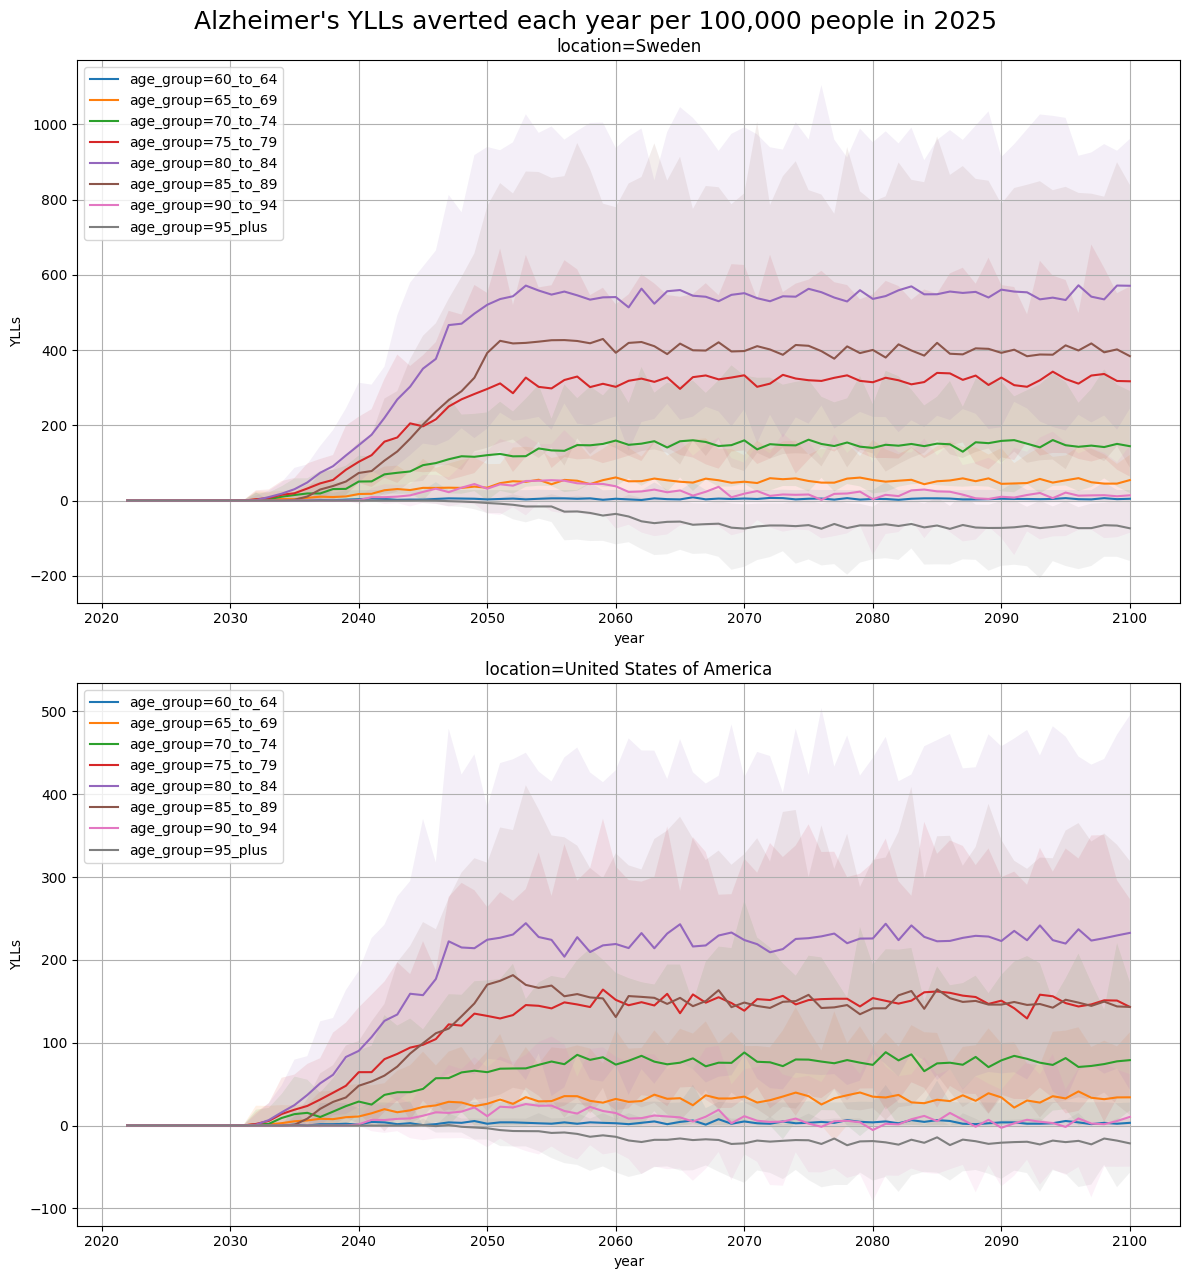

In [119]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="YLLs",
    suptitle=f"Alzheimer's YLLs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.grid(True)
plt.show()

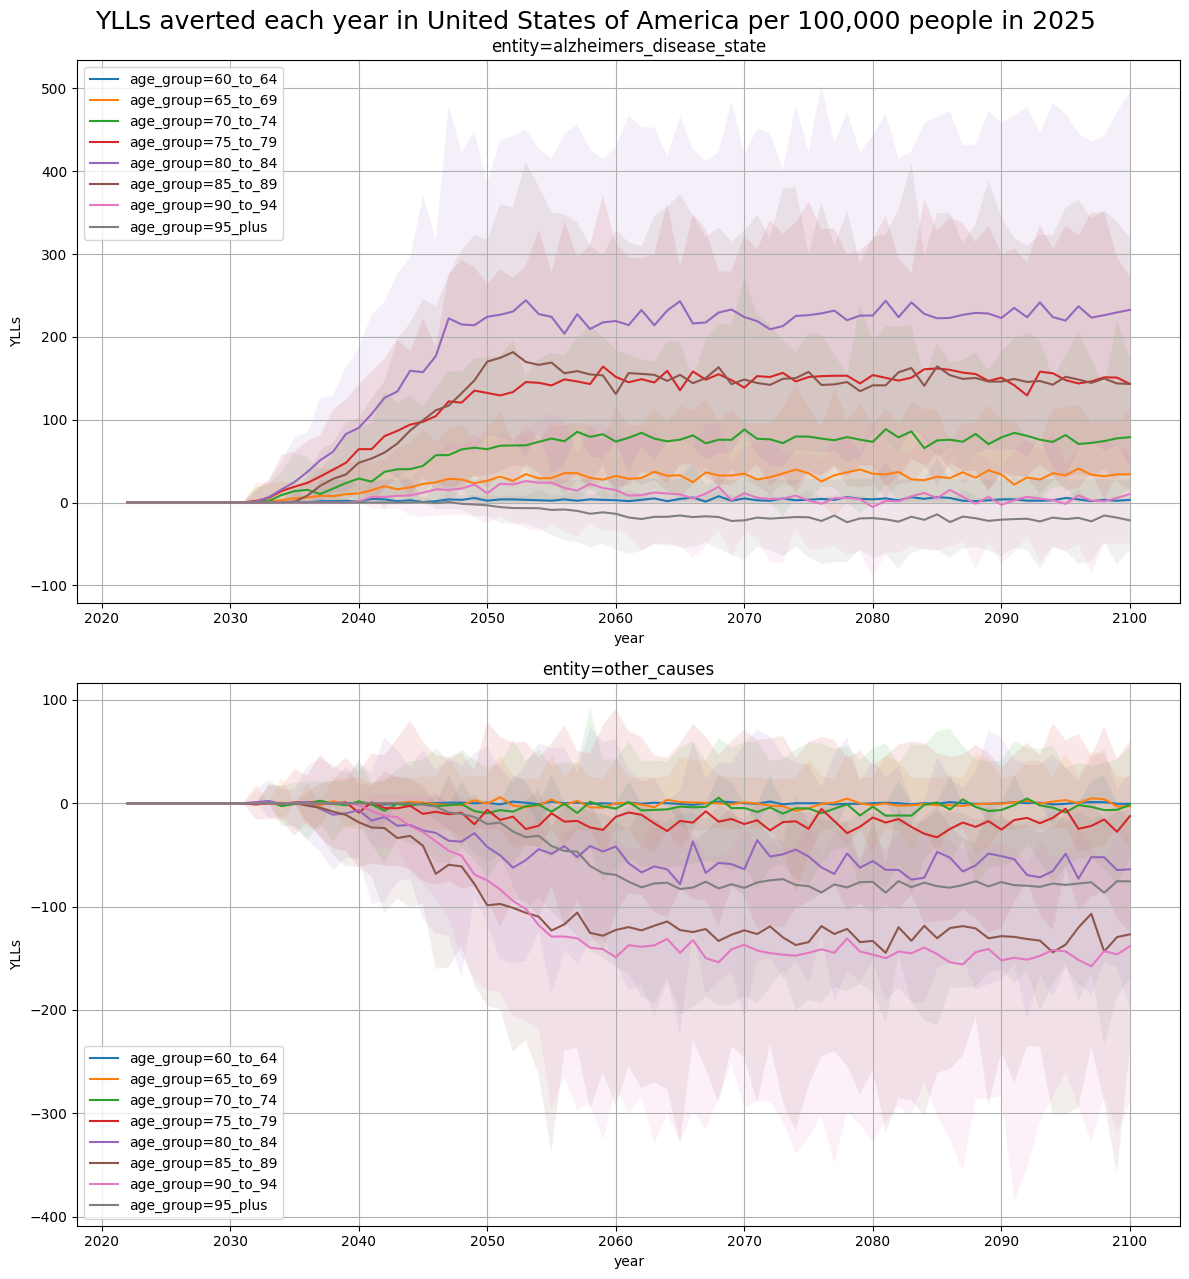

In [120]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="YLLs",
    suptitle=f"YLLs averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

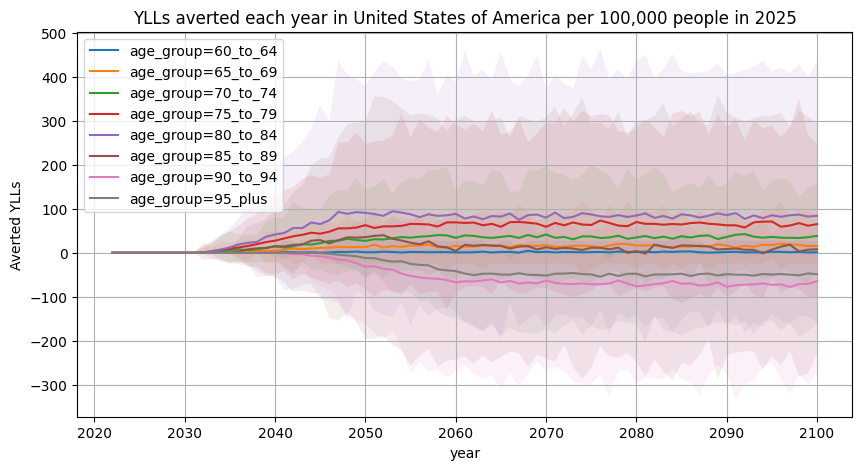

In [121]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="Averted YLLs",
    title=f"YLLs averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
ax.grid(True)
plt.show()

# Load YLDs and plot averted YLDs

In [122]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/sweden.hdf'])


85.325581 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
4265995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
4265995                              all_causes       cause        2100   
4265996                              all_causes       cause        2100   
4265997                              all_causes       cause        2100   
4265998                              all_causes       cause        2100   
4265999                              all_causes       cause        2100   

        input_draw measure                    scenario     sex  \
0              258    ylds                    baseline  Female   
1              258    ylds                    baseline  Female   
2              258    ylds                    baseline  Female   
3              258    ylds                    baseline    Male   
4              258    ylds                    baseline    Male   
...            ...     ...                         ...     ...   
4265995        446    ylds                    baseline    Male   
4265996        446    ylds                bbbm_testing  Female   
4265997        446    ylds                bbbm_testing    Male   
4265998        446    ylds  bbbm_testing_and_treatment  Female   
4265999        446    ylds  bbbm_testing_and_treatment    Male   

                                         sub_entity       value  \
0            alzheimers_blood_based_biomarker_state    0.000000   
1        alzheimers_mild_cognitive_impairment_state    0.000000   
2                          alzheimers_disease_state    0.000000   
3            alzheimers_blood_based_biomarker_state    0.000000   
4        alzheimers_mild_cognitive_impairment_state    0.000000   
...                                             ...         ...   
4265995                                  all_causes  256.726243   
4265996                                  all_causes  849.009726   
4265997                                  all_causes  256.726243   
4265998                                  all_causes  854.226142   
4265999                                  all_causes  257.702046   

                         location  
0                          Sweden  
1                          Sweden  
2                          Sweden  
3                          Sweden  
4                          Sweden  
...                           ...  
4265995  United States of America  
4265996  United States of America  
4265997  United States of America  
4265998  United States of America  
4265999  United States of America  

[4266000 rows x 12 columns]

In [123]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
# This converts years from int64 to int16
# convert_dtypes(averted_ylds, colname_to_dtype, inplace=True)
averted_ylds = averted_ylds.astype(colname_to_dtype, copy=False)
print_memory_usage(averted_ylds)
# This would convert integer years to Categorical
# convert_to_categorical(averted_ylds, inplace=True)
# print_memory_usage(averted_ylds)

85.325581 MB measure
39.821449 MB minuend
79.637449 MB subtrahend
27.026825 MB minuend re-indexed
54.044825 MB subtrahend re-indexed
54.044885 MB difference
73.949581 MB difference with reset index
76.793906 MB final difference
76.793906 MB
59.729906 MB


In [124]:
1086.443257 / 27.372526

39.69101196579373

In [125]:
averted_ylds.memory_usage(deep=True)

Index                   132
age_group           2845530
artifact_path       2844426
entity              2844336
entity_type         2844170
event_year          5688000
input_draw          2844756
measure             2844169
sex                 2844232
sub_entity          2845253
location            2844252
scenario            2844325
subtracted_from     2844325
value              22752000
dtype: int64

In [126]:
averted_ylds.dtypes

age_group          category
artifact_path      category
entity             category
entity_type        category
event_year            int16
input_draw         category
measure            category
sex                category
sub_entity         category
location           category
scenario           category
subtracted_from    category
value               float64
dtype: object

In [127]:
averted_ylds

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2843995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
2843995                              all_causes       cause        2100   
2843996                              all_causes       cause        2100   
2843997                              all_causes       cause        2100   
2843998                              all_causes       cause        2100   
2843999                              all_causes       cause        2100   

        input_draw measure     sex  \
0              258    ylds  Female   
1              258    ylds  Female   
2              258    ylds  Female   
3              258    ylds    Male   
4              258    ylds    Male   
...            ...     ...     ...   
2843995        199    ylds    Male   
2843996        446    ylds  Female   
2843997        446    ylds    Male   
2843998        446    ylds  Female   
2843999        446    ylds    Male   

                                         sub_entity                  location  \
0            alzheimers_blood_based_biomarker_state                    Sweden   
1        alzheimers_mild_cognitive_impairment_state                    Sweden   
2                          alzheimers_disease_state                    Sweden   
3            alzheimers_blood_based_biomarker_state                    Sweden   
4        alzheimers_mild_cognitive_impairment_state                    Sweden   
...                                             ...                       ...   
2843995                                  all_causes  United States of America   
2843996                                  all_causes  United States of America   
2843997                                  all_causes  United States of America   
2843998                                  all_causes  United States of America   
2843999                                  all_causes  United States of America   

                           scenario subtracted_from     value  
0                      bbbm_testing        baseline  0.000000  
1                      bbbm_testing        baseline  0.000000  
2                      bbbm_testing        baseline  0.000000  
3                      bbbm_testing        baseline  0.000000  
4                      bbbm_testing        baseline  0.000000  
...                             ...             ...       ...  
2843995  bbbm_testing_and_treatment        baseline -3.100351  
2843996                bbbm_testing        baseline  0.000000  
2843997                bbbm_testing        baseline  0.000000  
2843998  bbbm_testing_and_treatment        baseline -5.216416  
2843999  bbbm_testing_and_treatment        baseline -0.975803  

[2844000 rows x 13 columns]

In [128]:
averted_ylds.entity.unique()

['alzheimers_disease_and_other_dementias', 'treatment', 'all_causes']
Categories (3, object): ['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']

In [129]:
# All values are 0 in this sub-dataframe
averted_ylds.query("entity=='treatment'")

age_group                                      artifact_path  \
23700    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
23701    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
23702    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
23703    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
23704    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2836095   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2836096   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2836097   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2836098   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2836099   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw measure     sex  \
23700    treatment       cause        2022        258    ylds  Female   
23701    treatment       cause        2022        258    ylds  Female   
23702    treatment       cause        2022        258    ylds  Female   
23703    treatment       cause        2022        258    ylds  Female   
23704    treatment       cause        2022        258    ylds  Female   
...            ...         ...         ...        ...     ...     ...   
2836095  treatment       cause        2100        446    ylds    Male   
2836096  treatment       cause        2100        446    ylds    Male   
2836097  treatment       cause        2100        446    ylds    Male   
2836098  treatment       cause        2100        446    ylds    Male   
2836099  treatment       cause        2100        446    ylds    Male   

                      sub_entity                  location  \
23700      waiting_for_treatment                    Sweden   
23701           full_effect_long                    Sweden   
23702          full_effect_short                    Sweden   
23703         waning_effect_long                    Sweden   
23704        waning_effect_short                    Sweden   
...                          ...                       ...   
2836095       waning_effect_long  United States of America   
2836096      waning_effect_short  United States of America   
2836097     no_effect_after_long  United States of America   
2836098    no_effect_after_short  United States of America   
2836099  no_effect_never_treated  United States of America   

                           scenario subtracted_from  value  
23700                  bbbm_testing        baseline    0.0  
23701                  bbbm_testing        baseline    0.0  
23702                  bbbm_testing        baseline    0.0  
23703                  bbbm_testing        baseline    0.0  
23704                  bbbm_testing        baseline    0.0  
...                             ...             ...    ...  
2836095  bbbm_testing_and_treatment        baseline    0.0  
2836096  bbbm_testing_and_treatment        baseline    0.0  
2836097  bbbm_testing_and_treatment        baseline    0.0  
2836098  bbbm_testing_and_treatment        baseline    0.0  
2836099  bbbm_testing_and_treatment        baseline    0.0  

[1896000 rows x 13 columns]

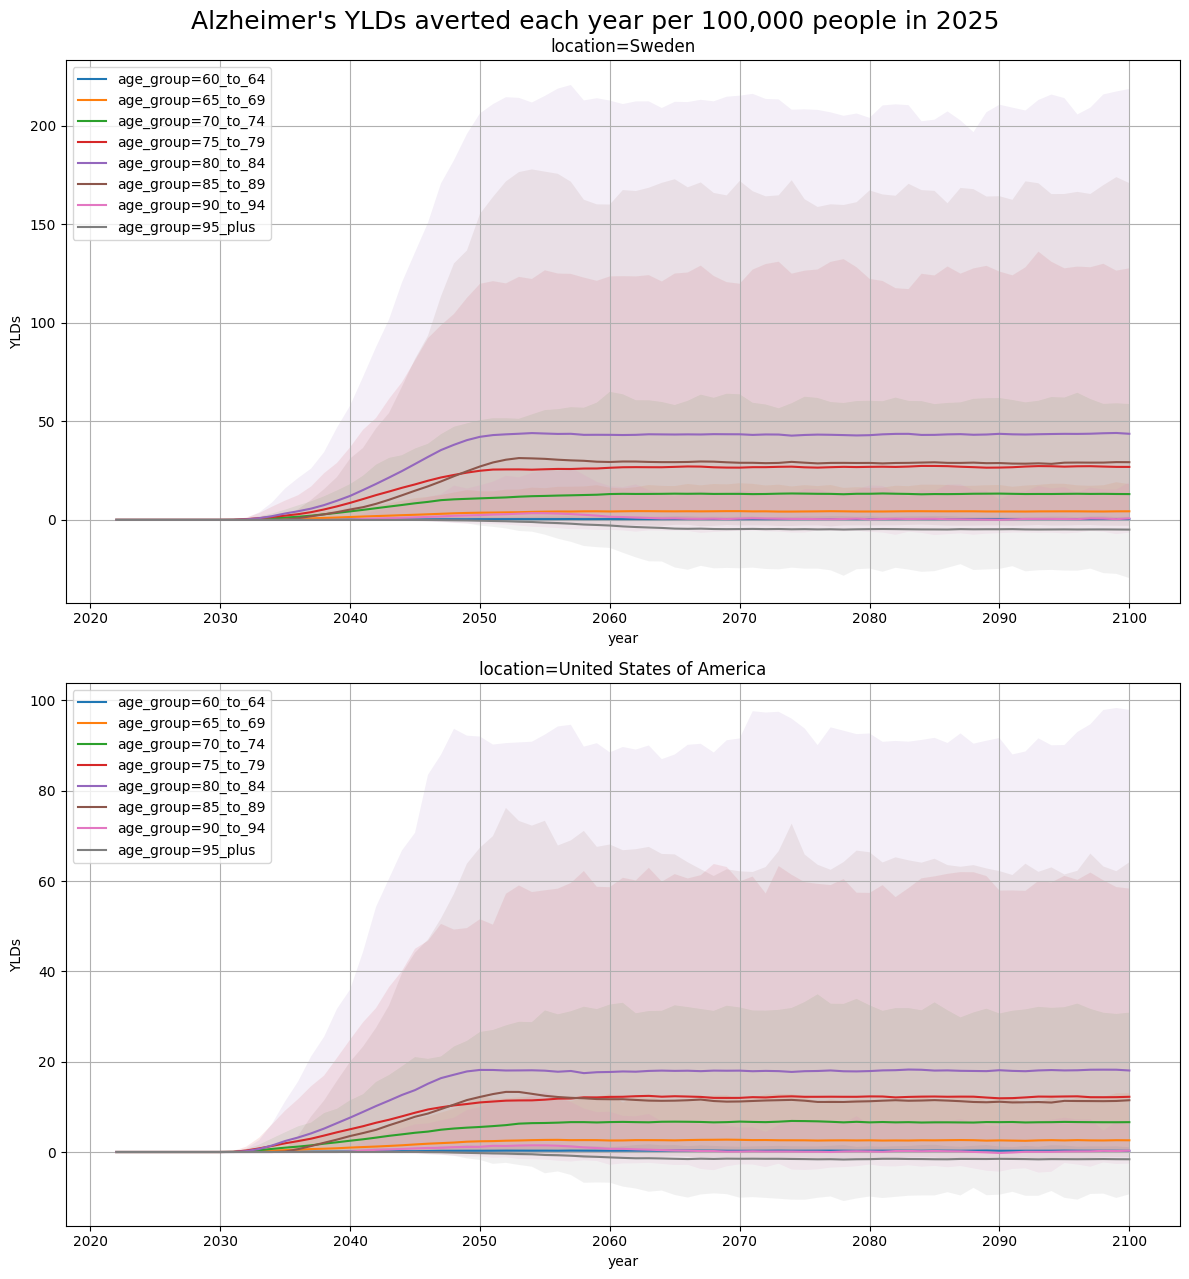

In [130]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_and_other_dementias'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"Alzheimer's YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

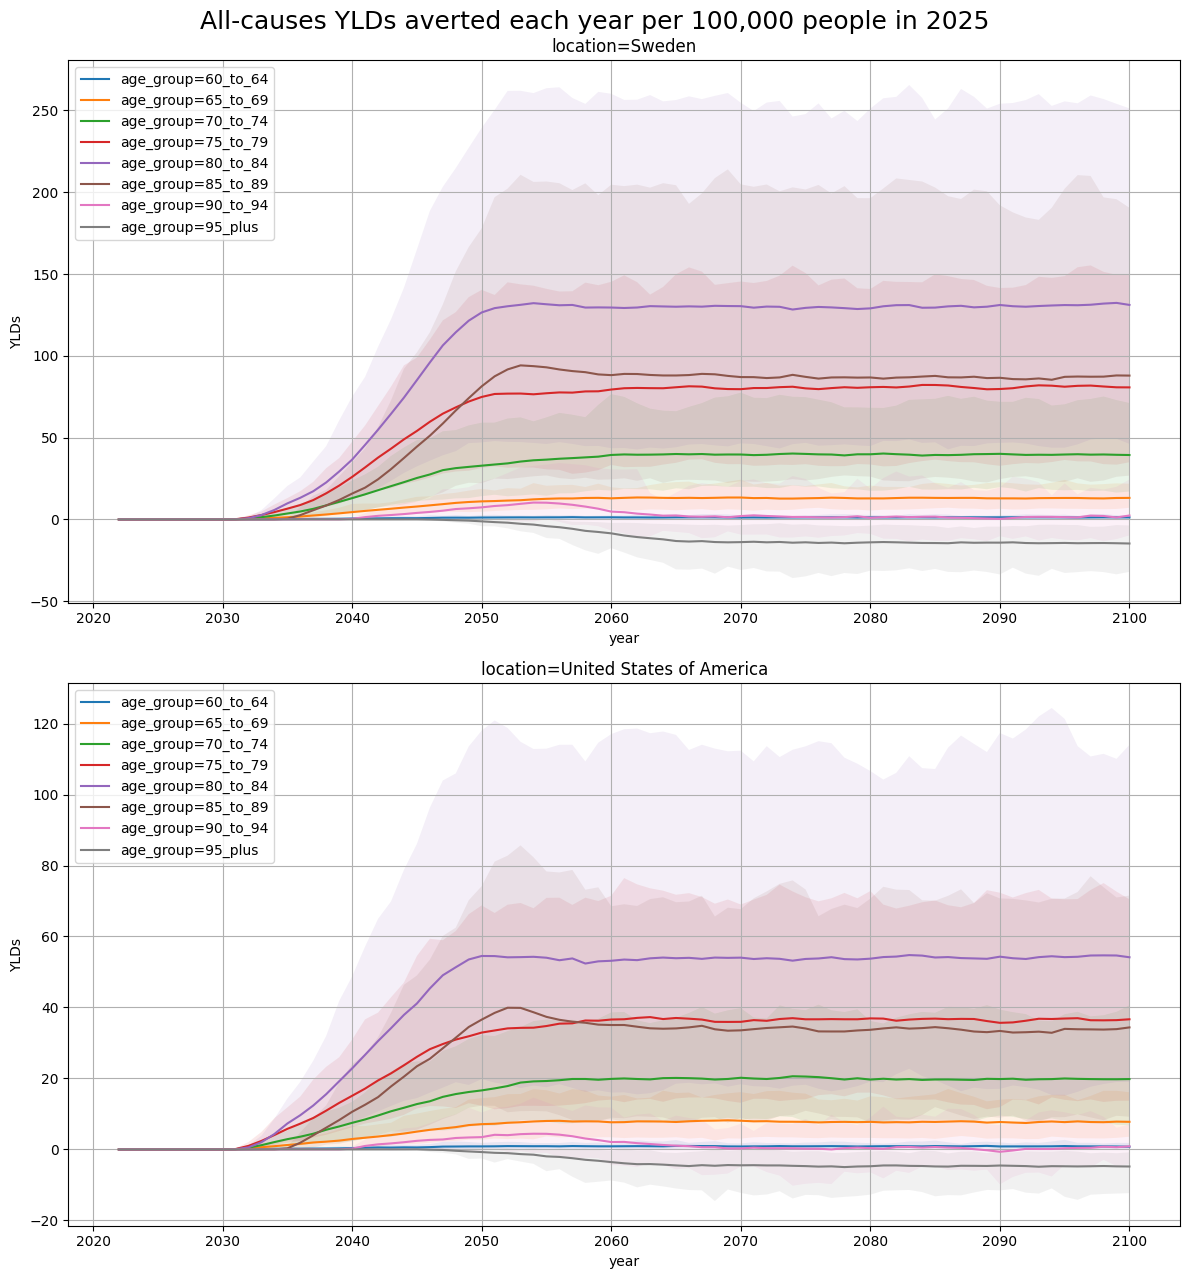

In [131]:
# I'm not sure why total YLDs averted is greater than Alzheimer's YLDs
# averted...
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'all_causes'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"All-causes YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

In [132]:
# Print current time to easily check if notebook ran all the way through
# vs. hitting an error somewhere above
import datetime
print(datetime.datetime.now())

2025-11-04 23:38:28.466576
